# Setting up the enviroment


In [ ]:
pip install xgboost

In [ ]:
import glob

import itertools

import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

import matplotlib.pyplot as plt

from numpy import load
import numpy as np
from numpy import save
import os
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from xgboost import XGBRegressor

# Loading features

## Defining Functions

In [ ]:
## Defining the method for reading Aesthetic Features from a file

def read_aesthetic_features(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            asf =[float(item) for item in line.split(',')] # convert to float type, using "," separator
    return asf

In [ ]:
## Defining the method for reading HMP Features from a file

def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [ ]:
## Defining the method for reading LBP Features from a file
def read_lbp(fname):
    with open(fname) as f:
        for line in f:
            LBP = [float(item) for item in line.split()]
    return LBP

In [ ]:
## Defining the method for reading ColorHistogram Features from a file

def read_ColorHistogram(fname):
    """Scan Color Histogram from file
    Input file contains RGB histogram,
    Return a matrix of (3,256)"""
    RGB_Hist = np.zeros((3,256))
    with open(fname) as f:
        i_l = 0 # line index
        for line in f:
            pairs = line.split()
            hist_dict = {int(p.split(':')[0]):int(p.split(':')[1]) for p in pairs}
            for idx in hist_dict.keys():
                RGB_Hist[i_l,idx] = hist_dict[idx]
            i_l += 1
    return RGB_Hist

In [ ]:
## Defining the method for reading C3D Features from a file

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

In [ ]:
## Defining the method for reading InceptionV3 Features from a file

def read_InceptionV3(fname):
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            InceptionV3_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 1000 bins, fill zeros
    InceptionV3 = np.zeros(1000)
    for idx in InceptionV3_temp.keys():
        InceptionV3[idx-1] = InceptionV3_temp[idx]            
    return InceptionV3

In [ ]:
## Defining the method for reading HOG Features from a file
def read_hog(fname):
    with open(fname) as f:
        for line in f:
            HOG = [float(item) for item in line.split()]
    return HOG

**NOTE:** All the features were loaded in Jupyter notebook in local machine and were saved and uploaded to drive in pickle format. 

These pickle format files were used to load the features in this Colab Notebook

## C3D Feature

In [ ]:
## Code from local machine
## Calling the method for fetching C3D features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the C3D features
my_namelist = [] # Creating a new list to store the names of the videos
for filename in glob.glob('Dev-set/C3D/*.txt'):
    s= read_C3D(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0])) ## Filename is "Dev-set/C3D\video10.txt"

## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
ground_truth.head()
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])
ground_truth.head()

## Creating dataframe for C3D feature
c3d = pd.DataFrame()
c3d["video"] = ground_truth['video']
c3d['c3d'] = ''
c3d.head() 

## Merging C3D feature values with ground truth dataframe
c3d = pd.merge(ground_truth, c3d , on='video')
c3d.index = c3d.video
del c3d['video']
c3d.head()


## Adding the list of values of C3D feature to appropriate column
for i in c3d.index:
    for j in my_namelist:
        if (i == j):
            c3d.at[i, 'c3d'] = my_numlist[my_namelist.index(j)]


## Replacing missing values by 0
c3d = c3d.replace(to_replace ='', value =0)

## Saving the dataframe using Pickle
c3d.to_pickle('Dev-loaded-features/c3d')

In [ ]:
c3d = pd.read_pickle('/content/drive/MyDrive/ML Assignment/c3d')

In [ ]:
c3d.head()

,short-term_memorability,long-term_memorability,c3d
video,,,
video3,0.924,0.846,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
video4,0.923,0.667,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."
video6,0.863,0.700,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05..."
video8,0.922,0.818,0
video10,0.950,0.900,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092..."


In [ ]:
## Finding rows with missing c3d values
(c3d[c3d.c3d == 0]).count()[1]

132

In [ ]:
## Dropping the rows with missing c3d values.
c3d = c3d[c3d.c3d != 0]

In [ ]:
c3d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5868 entries, video3 to video7493
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   short-term_memorability  5868 non-null   float64
 1   long-term_memorability   5868 non-null   float64
 2   c3d                      5868 non-null   object 
dtypes: float64(2), object(1)
memory usage: 183.4+ KB


## HMP Feature

In [ ]:
## Code from local machine

HMP_feature_list= []
video_names_list = []
for filename in glob.glob('Dev-set/HMP/*.txt'):
    name = ((filename.split('\\')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)

## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
ground_truth.head()
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])
ground_truth.head()

## Creating HMP dataframe
hmp = pd.DataFrame()
hmp["video"] = ground_truth['video']
hmp['hmp'] = ''
hmp.head() 

## Merging groundtruth and HMP dataframe
hmp = pd.merge(ground_truth, hmp , on='video')
hmp.index = hmp.video
del hmp['video']
hmp.head()

## Filling HMP values in the appropriate columns
for i in hmp.index:
    for j in video_names_list:
        if (i == j):
            hmp.at[i, 'hmp'] = HMP_feature_list[video_names_list.index(j)]

## Replacing missing values with 0 and saving the dataframe using picke
hmp = hmp.replace(to_replace ='', value =0)
hmp.to_pickle('Dev-loaded-features/hmp')

In [ ]:
hmp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/hmp')

In [ ]:
hmp.head()

,short-term_memorability,long-term_memorability,hmp
video,,,
video3,0.924,0.846,"[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ..."
video4,0.923,0.667,"[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0..."
video6,0.863,0.700,"[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ..."
video8,0.922,0.818,"[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ..."
video10,0.950,0.900,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2..."


In [ ]:
hmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, video3 to video7493
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   short-term_memorability  6000 non-null   float64
 1   long-term_memorability   6000 non-null   float64
 2   hmp                      6000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 187.5+ KB


In [ ]:
## Finding rows with missing hmp values
ind=[]
for i in hmp.index:
  if isinstance(hmp['hmp'][i],int):
    ind.append(i)
print("Total rows with no HMP Feature: ", len(ind))
print("Indexes of these rows are: ", ind)

Total rows with no HMP Feature:  99
Indexes of these rows are:  ['video26', 'video48', 'video166', 'video167', 'video239', 'video244', 'video260', 'video261', 'video412', 'video413', 'video656', 'video681', 'video1655', 'video1657', 'video1658', 'video1662', 'video1663', 'video1664', 'video1665', 'video1669', 'video2376', 'video2377', 'video2380', 'video2381', 'video2382', 'video2386', 'video2387', 'video2388', 'video2389', 'video2391', 'video2394', 'video2395', 'video2598', 'video2600', 'video2603', 'video2605', 'video2607', 'video2608', 'video2609', 'video2610', 'video2613', 'video2614', 'video2615', 'video2616', 'video2618', 'video2619', 'video2620', 'video2621', 'video2622', 'video2623', 'video2627', 'video2629', 'video4116', 'video4117', 'video4118', 'video4119', 'video4120', 'video4121', 'video4122', 'video4123', 'video4124', 'video4125', 'video4129', 'video4131', 'video4138', 'video4801', 'video4802', 'video4805', 'video4876', 'video4877', 'video6545', 'video6547', 'video6550', 

In [ ]:
## Dropping rows with missing values
hmp.drop(ind, inplace=True)

In [ ]:
hmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5901 entries, video3 to video7493
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   short-term_memorability  5901 non-null   float64
 1   long-term_memorability   5901 non-null   float64
 2   hmp                      5901 non-null   object 
dtypes: float64(2), object(1)
memory usage: 184.4+ KB


## InceptionV3

In [ ]:
## Code from Local Machine
## Calling the function
my_numlist= []
full_namelist = []
my_namelist = []
for filename in glob.glob('Dev-set/InceptionV3/*.txt'):
    name = ((filename.split('\\')[-1]).split('.')[0])
    full_namelist.append(name)
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0]).split('-')[0])
    InceptionV3_features = read_InceptionV3(filename)
    my_numlist.append(InceptionV3_features)


## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])


## Creating InceptionV3 Dataframe
InceptionV3 = pd.DataFrame()
InceptionV3["video"] = ground_truth['video']
InceptionV3['video-0'] = ''
InceptionV3['video-56'] = ''
InceptionV3['video-112' ] = ''
InceptionV3.head() 


## Merging ground truth with InceptionV3 dataframe
InceptionV3 = pd.merge(ground_truth, InceptionV3 , on='video')
InceptionV3.index = InceptionV3.video
del InceptionV3['video']
InceptionV3.head()


## Filling in the values in appropriate column
for i in InceptionV3.index:
    for j in full_namelist:
        if (i == j.split('-')[0]):
            if (j.split('-')[-1] == "0"):
                InceptionV3.at[i, 'video-0'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "56"):
                InceptionV3.at[i, 'video-56'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "112"):
                InceptionV3.at[i, 'video-112'] = my_numlist[full_namelist.index(j)]


## Replacing missing values with 0 and saving the dataframe using pickle
InceptionV3 = InceptionV3.replace(to_replace ='', value =0)
InceptionV3.to_pickle('Dev-loaded-features/inception_v3')

In [ ]:
inceptionv3 = pd.read_pickle('/content/drive/MyDrive/ML Assignment/inception_v3')

In [ ]:
inceptionv3.head()

,short-term_memorability,long-term_memorability,video-0,video-56,video-112
video,,,,,
video3,0.924,0.846,0,0,0
video4,0.923,0.667,0,0,0
video6,0.863,0.700,"[2.926813e-18, 3.022254e-19, 4.139101e-19, 2.9...","[9.85284e-13, 3.953588e-18, 7.851983e-17, 2.91...","[1.93123e-18, 5.784305e-21, 3.029372e-20, 2.83..."
video8,0.922,0.818,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
video10,0.950,0.900,0,0,0


In [ ]:
## Finding rows with missing hmp values
ind_0=[]
ind_56=[]
ind_112=[]
for i in inceptionv3.index:
  if isinstance(inceptionv3['video-0'][i],int):
    ind_0.append(i)
  if isinstance(inceptionv3['video-56'][i],int):
    ind_56.append(i)
  if isinstance(inceptionv3['video-112'][i],int):
    ind_112.append(i)
print("Total rows with no inception Feature for frame 0: ", len(ind_0))
print("Total rows with no inception Feature for frame 56: ", len(ind_56))
print("Total rows with no inception Feature for frame 112: ", len(ind_112))
print("Selecting all indexed which are missing any of these features...")

ind = ind_0 + ind_56 + ind_112
ind_final = list(set(ind))
print("Total rows with no inception Feature: ", len(ind_final))
print("Indexes of these rows are: ", ind_final)

Total rows with no inception Feature for frame 0:  2730
Total rows with no inception Feature for frame 56:  2724
Total rows with no inception Feature for frame 112:  2730
Selecting all indexed which are missing any of these features...
Total rows with no inception Feature:  2751
Indexes of these rows are:  ['video3150', 'video1997', 'video282', 'video3275', 'video3659', 'video3686', 'video3425', 'video1213', 'video133', 'video1656', 'video1152', 'video1039', 'video3387', 'video2445', 'video2414', 'video3654', 'video1022', 'video1184', 'video2052', 'video2638', 'video2974', 'video3348', 'video1021', 'video1050', 'video1527', 'video1877', 'video3750', 'video2239', 'video1741', 'video2087', 'video1857', 'video2399', 'video3101', 'video2203', 'video3817', 'video2583', 'video2801', 'video3192', 'video733', 'video1679', 'video2610', 'video1887', 'video2423', 'video1943', 'video3411', 'video3194', 'video2323', 'video2623', 'video2097', 'video1858', 'video2658', 'video1112', 'video2339', 'vide

In [ ]:
## Dropping rows with missing values
inceptionv3.drop(ind_final, inplace=True)

In [ ]:
inceptionv3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3249 entries, video6 to video7493
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   short-term_memorability  3249 non-null   float64
 1   long-term_memorability   3249 non-null   float64
 2   video-0                  3249 non-null   object 
 3   video-56                 3249 non-null   object 
 4   video-112                3249 non-null   object 
dtypes: float64(2), object(3)
memory usage: 152.3+ KB


## LBP

In [ ]:
## Code from Local Machine
## Calling the method for fetching LBP features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the LBP features
my_namelist = [] # Creating a new list to store the names of the videos
full_namelist = []
for filename in glob.glob('Dev-set/LBP/*.txt'):
    s = read_lbp(filename)
    my_numlist.append(s)
    full_namelist.append(((filename.split('\\')[-1]).split('.')[0])) 
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0]).split('-')[0])


## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])


## Creating empty dataframe for LBP
lbp = pd.DataFrame()
lbp["video"] = ground_truth['video']
lbp['video-0'] = ''
lbp['video-56'] = ''
lbp['video-112' ] = ''
lbp.head() 

## Merging dataframe with ground truth
lbp = pd.merge(ground_truth, lbp , on='video')
lbp.index = lbp.video
del lbp['video']
lbp.head()

## Filling the values in appropriate columns
for i in lbp.index:
    for j in full_namelist:
        if (i == j.split('-')[0]):
            if (j.split('-')[-1] == "0"):
                lbp.at[i, 'video-0'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "56"):
                lbp.at[i, 'video-56'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "112"):
                lbp.at[i, 'video-112'] = my_numlist[full_namelist.index(j)]


## Replacing missing values with 0 and saving the dataframe using pickle
lbp = lbp.replace(to_replace ='', value =0)
lbp.to_pickle('Dev-loaded-features/lbp')

In [ ]:
lbp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/lbp')

In [ ]:
lbp.head()

,short-term_memorability,long-term_memorability,video-0,video-56,video-112
video,,,,,
video3,0.924,0.846,0,0,0
video4,0.923,0.667,"[0.00966435, 0.00291811, 0.00219425, 0.0018682...","[0.01016445, 0.00291377, 0.00232832, 0.0020452...","[0.00991127, 0.00292679, 0.00233845, 0.0020862..."
video6,0.863,0.700,"[0.01084008, 0.00189525, 0.00154128, 0.0009606...","[0.00749759, 0.00117043, 0.00096595, 0.0007257...","[0.00782986, 0.00120563, 0.00085166, 0.0006939..."
video8,0.922,0.818,"[0.01163436, 0.00431472, 0.00321277, 0.0019121...","[0.01338397, 0.00459394, 0.00335214, 0.0026601...","[0.01097222, 0.00419367, 0.0028178, 0.00211709..."
video10,0.950,0.900,0,0,0


In [ ]:
## Finding rows with missing lbp values
ind_0=[]
ind_56=[]
ind_112=[]
for i in lbp.index:
  if isinstance(lbp['video-0'][i],int):
    ind_0.append(i)
  if isinstance(lbp['video-56'][i],int):
    ind_56.append(i)
  if isinstance(lbp['video-112'][i],int):
    ind_112.append(i)
print("Total rows with no inception Feature for frame 0: ", len(ind_0))
print("Total rows with no inception Feature for frame 56: ", len(ind_56))
print("Total rows with no inception Feature for frame 112: ", len(ind_112))
print("Selecting all indexed which are missing any of these features...")

ind = ind_0 + ind_56 + ind_112
ind_final = list(set(ind))
print("Total rows with no inception Feature: ", len(ind_final))
print("Indexes of these rows are: ", ind_final)

Total rows with no inception Feature for frame 0:  2507
Total rows with no inception Feature for frame 56:  2511
Total rows with no inception Feature for frame 112:  2509
Selecting all indexed which are missing any of these features...
Total rows with no inception Feature:  2534
Indexes of these rows are:  ['video3150', 'video1997', 'video282', 'video3275', 'video3659', 'video3686', 'video3425', 'video1213', 'video133', 'video1656', 'video1152', 'video1039', 'video3387', 'video2445', 'video2414', 'video3654', 'video1022', 'video1184', 'video2052', 'video2638', 'video2974', 'video3348', 'video1021', 'video1050', 'video1527', 'video1877', 'video3750', 'video2239', 'video1741', 'video2087', 'video1857', 'video2399', 'video3101', 'video2203', 'video2583', 'video2801', 'video3192', 'video1679', 'video2610', 'video1887', 'video2423', 'video1943', 'video3411', 'video3194', 'video2323', 'video2623', 'video2097', 'video1858', 'video2658', 'video1112', 'video2339', 'video3724', 'video2708', 'vid

In [ ]:
## Dropping rows with missing values
lbp.drop(ind_final, inplace=True)

In [ ]:
lbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3466 entries, video4 to video7493
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   short-term_memorability  3466 non-null   float64
 1   long-term_memorability   3466 non-null   float64
 2   video-0                  3466 non-null   object 
 3   video-56                 3466 non-null   object 
 4   video-112                3466 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.5+ KB


In [ ]:
## Finding maximum number of features in LBP
max_f = 0
for i in lbp.index:
  if max_f < len(lbp['video-0'][i]):
    max_f = len(lbp['video-0'][i])
  if max_f < len(lbp['video-56'][i]):
    max_f = len(lbp['video-56'][i])
  if max_f < len(lbp['video-112'][i]):
    max_f = len(lbp['video-112'][i])

print("Maximum number of features are: ", max_f)

Maximum number of features are:  122


## Aesthetics

In [ ]:
## Code from Local Machine

## Calling the method for fetching Aesthetic features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the Aesthetic features
my_namelist = [] # Creating a new list to store the names of the videos
for filename in glob.glob('Dev-set/Aesthetic_Features/aesthetic_feat_dev-set_mean/*.txt'):
    s= read_aesthetic_features(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0])) ## Filename is "Dev-set/aesthetic\video10.txt"


## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
ground_truth.head()
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])
ground_truth.head()

## Creating empty dataframe for aesthetic Feature
asf = pd.DataFrame()
asf["video"] = ground_truth['video']
asf['aesthetic_feat_dev-set_mean'] = ''
asf['aesthetic_feat_dev-set_median'] = ''
asf.head() 

## Merging dataframe with ground truth
asf = pd.merge(ground_truth, asf , on='video')
asf.index = asf.video
del asf['video']
asf.head()

## Adding mean values to dataframe
for i in asf.index:
    for j in my_namelist:
        if (i == j):
            asf.at[i, 'aesthetic_feat_dev-set_mean'] = my_numlist[my_namelist.index(j)]


## Adding Median Values to the dataframe
my_numlist= [] # Creating new list to store the aesthetic features
my_namelist = [] # Creating a new list to store the names of the videos
for filename in glob.glob('Dev-set/Aesthetic_Features/aesthetic_feat_dev-set_median/*.txt'):
    s= read_aesthetic_features(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0])) ## Filename is "Dev-set/aesthetic\video10.txt"

for i in asf.index:
    for j in my_namelist:
        if (i == j):
            asf.at[i, 'aesthetic_feat_dev-set_median'] = my_numlist[my_namelist.index(j)]


asf = asf.replace(to_replace ='', value =0)
asf.to_pickle('Dev-loaded-features/aesthetic_feature')

In [ ]:
aesthetics = pd.read_pickle('/content/drive/MyDrive/ML Assignment/aesthetic_feature')
aesthetics.head()

,short-term_memorability,long-term_memorability,aesthetic_feat_dev-set_mean,aesthetic_feat_dev-set_median
video,,,,
video3,0.924,0.846,"[0.18389, 0.713733, 0.202302, 0.610132, 0.1242...","[0.180874, 0.715626, 0.19893, 0.610453, 0.1216..."
video4,0.923,0.667,"[0.147255, 0.550718, 0.460299, 0.424981, 0.341...","[0.146076, 0.55007, 0.460729, 0.424397, 0.3418..."
video6,0.863,0.700,"[0.063933, 0.826933, 0.214129, 0.719341, 0.130...","[0.063898, 0.827439, 0.211925, 0.720297, 0.129..."
video8,0.922,0.818,"[0.367527, 0.133869, 0.746074, 0.169317, 0.696...","[0.380539, 0.134683, 0.746891, 0.171604, 0.697..."
video10,0.950,0.900,"[0.402878, 0.389358, 0.564687, 0.400378, 0.471...","[0.427258, 0.381448, 0.582746, 0.409475, 0.489..."


In [ ]:
## Finding rows with missing lbp values
ind_mean=[]
ind_median=[]
for i in aesthetics.index:
  if isinstance(aesthetics['aesthetic_feat_dev-set_mean'][i],int):
    ind_mean.append(i)
  if isinstance(aesthetics['aesthetic_feat_dev-set_median'][i],int):
    ind_median.append(i)
print("Total rows with no inception Feature for mean: ", len(ind_mean))
print("Total rows with no inception Feature for median: ", len(ind_median))
print("Selecting all indexed which are missing any of these features...")

ind = ind_mean + ind_median
ind_final = list(set(ind))
print("Total rows with no inception Feature: ", len(ind_final))
print("Indexes of these rows are: ", ind_final)

Total rows with no inception Feature for mean:  0
Total rows with no inception Feature for median:  0
Selecting all indexed which are missing any of these features...
Total rows with no inception Feature:  0
Indexes of these rows are:  []


NOTE: There are no missing values for Aesthetics Feature

## ColorHistogram

In [ ]:
## Code from Local Machine

## Calling the method for fetching ColorHistogram features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the ColorHistogram features
my_namelist = [] # Creating a new list to store the names of the videos
full_namelist = []
for filename in glob.glob('Dev-set/ColorHistogram/*.txt'):
    s= read_ColorHistogram(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0]).split('-')[0]) ## Filename is "Dev-set/ColorHistogram\video4-0.txt"
    full_namelist.append(((filename.split('\\')[-1]).split('.')[0]))


## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])
CH_features = pd.DataFrame()
CH_features["video"] = ground_truth['video']
CH_features.info()

## Adding new columns to CH_Feature
CH_features['video-0'] = ''
CH_features['video-56'] = ''
CH_features['video-112' ] = ''
CH_features.head()

## Merging dataframe with Ground Truth
CH_features = pd.merge(ground_truth, CH_features , on='video')
CH_features.index = CH_features.video
del CH_features['video']
CH_features.head()

## Filling the values to appropriate columns
for i in CH_features.index:
    for j in full_namelist:
        if (i == j.split('-')[0]):
            if (j.split('-')[-1] == "0"):
                CH_features.at[i, 'video-0'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "56"):
                CH_features.at[i, 'video-56'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "112"):
                CH_features.at[i, 'video-112'] = my_numlist[full_namelist.index(j)]


## Replacing missing values with 0
CH_features = CH_features.replace(to_replace ='', value =0)
CH_features.to_pickle('Dev-loaded-features/color_histogram')

In [ ]:
ch = pd.read_pickle('/content/drive/MyDrive/ML Assignment/color_histogram')

In [ ]:
ch.head()

,short-term_memorability,long-term_memorability,video-0,video-56,video-112
video,,,,,
video3,0.924,0.846,0,0,0
video4,0.923,0.667,"[[21542.0, 5063.0, 9901.0, 6499.0, 11245.0, 88...","[[16911.0, 5276.0, 10181.0, 7367.0, 9852.0, 99...","[[19416.0, 5417.0, 9368.0, 7555.0, 9377.0, 859..."
video6,0.863,0.700,"[[458836.0, 65035.0, 39208.0, 21082.0, 31064.0...","[[542409.0, 94466.0, 79806.0, 37750.0, 56638.0...","[[543149.0, 89806.0, 70010.0, 33146.0, 55169.0..."
video8,0.922,0.818,"[[42.0, 11.0, 14.0, 13.0, 27.0, 30.0, 83.0, 10...","[[0.0, 5.0, 5.0, 10.0, 5.0, 19.0, 21.0, 48.0, ...","[[8.0, 3.0, 6.0, 7.0, 28.0, 48.0, 88.0, 135.0,..."
video10,0.950,0.900,0,0,0


In [ ]:
## Finding rows with missing hmp values
ind_0=[]
ind_56=[]
ind_112=[]
for i in ch.index:
  if isinstance(ch['video-0'][i],int):
    ind_0.append(i)
  if isinstance(ch['video-56'][i],int):
    ind_56.append(i)
  if isinstance(ch['video-112'][i],int):
    ind_112.append(i)
print("Total rows with no inception Feature for frame 0: ", len(ind_0))
print("Total rows with no inception Feature for frame 56: ", len(ind_56))
print("Total rows with no inception Feature for frame 112: ", len(ind_112))
print("Selecting all indexed which are missing any of these features...")

ind = ind_0 + ind_56 + ind_112
ind_final = list(set(ind))
print("Total rows with no inception Feature: ", len(ind_final))
print("Indexes of these rows are: ", ind_final)

Total rows with no inception Feature for frame 0:  2329
Total rows with no inception Feature for frame 56:  2326
Total rows with no inception Feature for frame 112:  2327
Selecting all indexed which are missing any of these features...
Total rows with no inception Feature:  2347
Indexes of these rows are:  ['video3150', 'video1997', 'video282', 'video3275', 'video3425', 'video1213', 'video133', 'video1656', 'video1152', 'video1039', 'video6702', 'video3387', 'video2445', 'video2414', 'video1022', 'video1184', 'video2052', 'video2638', 'video2974', 'video3348', 'video1021', 'video1050', 'video1527', 'video1877', 'video906', 'video2239', 'video1741', 'video2087', 'video1857', 'video2399', 'video3101', 'video2203', 'video2583', 'video2801', 'video3192', 'video1679', 'video2610', 'video1887', 'video2423', 'video1943', 'video3411', 'video3194', 'video2323', 'video2623', 'video2097', 'video1858', 'video2658', 'video1112', 'video2339', 'video2708', 'video1609', 'video1174', 'video2742', 'vide

In [ ]:
## Dropping rows with missing values
ch.drop(ind_final, inplace=True)

In [ ]:
ch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3653 entries, video4 to video7493
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   short-term_memorability  3653 non-null   float64
 1   long-term_memorability   3653 non-null   float64
 2   video-0                  3653 non-null   object 
 3   video-56                 3653 non-null   object 
 4   video-112                3653 non-null   object 
dtypes: float64(2), object(3)
memory usage: 171.2+ KB


## HOG

In [ ]:
## Code from Local Machine
## Calling the method for fetching HOG features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the HOG features
my_namelist = [] # Creating a new list to store the names of the videos
full_namelist = []
for filename in glob.glob('Dev-set/HOG/*.txt'):
    s= read_hog(filename)
    my_numlist.append(s)
    full_namelist.append(((filename.split('\\')[-1]).split('.')[0])) 
    my_namelist.append(((filename.split('\\')[-1]).split('.')[0]).split('-')[0])



## Adding ground truth to the dataframe
ground_truth = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')
#Dropping annotation coulumn from ground truth as we dont need them
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
# Cleanig the video name
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0])


## Creating new dataframe for HOG
hog = pd.DataFrame()
hog["video"] = ground_truth['video']
hog['video-0'] = ''
hog['video-56'] = ''
hog['video-112' ] = ''
hog.head() 

## Merging HOG with Ground truth
hog = pd.merge(ground_truth, hog , on='video')
hog.index = hog.video
del hog['video']
hog.head()


## Filling in the values in the dataframe at appropriate columns
for i in hog.index:
    for j in full_namelist:
        if (i == j.split('-')[0]):
            if (j.split('-')[-1] == "0"):
                hog.at[i, 'video-0'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "56"):
                hog.at[i, 'video-56'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "112"):
                hog.at[i, 'video-112'] = my_numlist[full_namelist.index(j)]

## Replacing missing values with 0 and saving them using pickle
hog = hog.replace(to_replace ='', value =0)
hog.to_pickle('Dev-loaded-features/hog')

# Spearman Coefficient Function

In [ ]:
## Function definition to get Spearman Coefficient score
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# Model 1: Neural Network implemented using Keras

Reference - Multi-modal Ensemble Models for Predicting Video
Memorability


Conveting the featured into a numpy array for dense networks.

## Convolution 3D Feature

In [ ]:
## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
result_array.shape

(5868, 101)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D


<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
X_arrC3D.shape

(5868, 101)

In [ ]:
y = c3d[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrC3D, y, test_size=0.2, random_state=42)

In [ ]:
print("Train set has total {0}".format(len(x_train)))
print("Test set has total {0}".format(len(x_test)))
print("Y_Test set has total {0}".format(len(y_test)))
print("Y_Train set has total {0}".format(len(y_train)))

Train set has total 4694
Test set has total 1174
Y_Test set has total 1174
Y_Train set has total 4694


In [ ]:
print(x_train.shape)

(4694, 101)


In [ ]:
n_cols = x_train.shape[1]
n_cols

101

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Epoch 1/30
103/103 [==============================] - 1s 4ms/step - loss: 0.2851 - accuracy: 0.5875 - val_loss: 0.0211 - val_accuracy: 0.7090
Epoch 2/30
103/103 [==============================] - 0s 3ms/step - loss: 0.0527 - accuracy: 0.5423 - val_loss: 0.0174 - val_accuracy: 0.7111
Epoch 3/30
103/103 [==============================] - 0s 3ms/step - loss: 0.0422 - accuracy: 0.5851 - val_loss: 0.0146 - val_accuracy: 0.7197
Epoch 4/30
103/103 [==============================] - 0s 3ms/step - loss: 0.0373 - accuracy: 0.5984 - val_loss: 0.0142 - val_accuracy: 0.7211
Epoch 5/30
103/103 [==============================] - 0s 3ms/step - loss: 0.0338 - accuracy: 0.6301 - val_loss: 0.0136 - val_accuracy: 0.7211
Epoch 6/30
103/103 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.6243 - val_loss: 0.0149 - val_accuracy: 0.7211
Epoch 7/30
103/103 [==============================] - 0s 3ms/step - loss: 0.0287 - accuracy: 0.6516 - val_loss: 0.0142 - val_accuracy: 0.7211


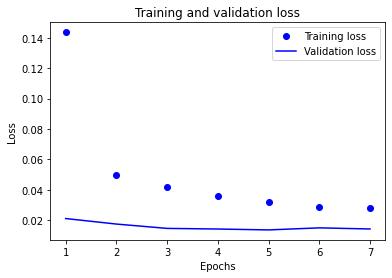

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#test set predictions
predictions_test = model.predict(x_test)
print(predictions_test)

[[0.8366022  0.7619962 ]
 [0.7964587  0.74390304]
 [0.81275034 0.74645895]
 ...
 [0.78030384 0.72025114]
 [0.80327356 0.740795  ]
 [0.8182596  0.7534857 ]]


In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.237
The Spearman's correlation coefficient is: 0.064


In [ ]:
# Saving the model
model.save('/content/drive/MyDrive/ML Assignment/Trained_Models/C3D_NN.h5')

## HMP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y = hmp[['short-term_memorability','long-term_memorability']].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_arrHMP, y, test_size=0.2, random_state=42)

In [ ]:
n_cols = x_train.shape[1]
n_cols

6075

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Epoch 1/30
104/104 [==============================] - 1s 10ms/step - loss: 0.0132 - accuracy: 0.7049 - val_loss: 0.0139 - val_accuracy: 0.7062
Epoch 2/30
104/104 [==============================] - 1s 8ms/step - loss: 0.0131 - accuracy: 0.7049 - val_loss: 0.0139 - val_accuracy: 0.7062
Epoch 3/30
104/104 [==============================] - 1s 9ms/step - loss: 0.0132 - accuracy: 0.7049 - val_loss: 0.0140 - val_accuracy: 0.7062


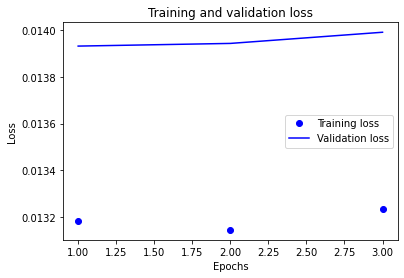

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#test set predictions
predictions_test = model.predict(x_test)
print(predictions_test)

[[0.8778858  0.8026577 ]
 [0.88393414 0.8094818 ]
 [0.8666573  0.78971577]
 ...
 [0.8795675  0.80386794]
 [0.8412963  0.7595017 ]
 [0.8629156  0.7849977 ]]


In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.254
The Spearman's correlation coefficient is: 0.113


In [ ]:
# Saving the model
model.save('/content/drive/MyDrive/ML Assignment/Trained_Models/HMP_NN.h5')  # creates a HDF5 file 'my_model.h5'

## LBP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

In [ ]:
y = lbp[['short-term_memorability','long-term_memorability']].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_arrLBP, y, test_size=0.2, random_state=42)

In [ ]:
n_cols = x_train.shape[1]
n_cols

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#test set predictions
predictions_test = model.predict(x_test)
print(predictions_test)

In [ ]:
Get_score(predictions_test, y_test)

In [ ]:
# Saving the model
model.save('/content/drive/MyDrive/ML Assignment/Trained_Models/LBP_NN.h5')  # creates a HDF5 file 'my_model.h5'

## InceptionV3

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 3000))

for i in inceptionv3.index:
  while len(inceptionv3['video-0'][i]) < 1000:
    inceptionv3['video-0'][i] = np.append((inceptionv3['video-0'][i]), 0)
  while len(inceptionv3['video-56'][i]) < 1000:
    inceptionv3['video-56'][i] = np.append((inceptionv3['video-56'][i]), 0)
  while len(inceptionv3['video-112'][i]) < 1000:
    inceptionv3['video-112'][i] = np.append((inceptionv3['video-112'][i]), 0)
  res = np.hstack((inceptionv3['video-0'][i], inceptionv3['video-56'][i], inceptionv3['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_inception = result_array
del result_array
print(type(X_arr_inception))
X_arr_inception

<class 'numpy.ndarray'>


array([[2.926813e-18, 3.022254e-19, 4.139101e-19, ..., 3.913046e-23,
        2.295526e-20, 2.015046e-17],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.619819e-33, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.332495e-25, 2.549710e-34, 7.246693e-37, ..., 0.000000e+00,
        0.000000e+00, 6.700695e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [ ]:
y = inceptionv3[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arr_inception, y, test_size=0.2, random_state=42)

In [ ]:
n_cols = x_train.shape[1]
n_cols

3000

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Epoch 1/30
57/57 [==============================] - 1s 9ms/step - loss: 0.2931 - accuracy: 0.5832 - val_loss: 0.0180 - val_accuracy: 0.6744
Epoch 2/30
57/57 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.5957 - val_loss: 0.0200 - val_accuracy: 0.6949
Epoch 3/30
57/57 [==============================] - 0s 6ms/step - loss: 0.0416 - accuracy: 0.6062 - val_loss: 0.0150 - val_accuracy: 0.6949
Epoch 4/30
57/57 [==============================] - 0s 7ms/step - loss: 0.0354 - accuracy: 0.6057 - val_loss: 0.0151 - val_accuracy: 0.6974
Epoch 5/30
57/57 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.5884 - val_loss: 0.0135 - val_accuracy: 0.6974
Epoch 6/30
57/57 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.6553 - val_loss: 0.0160 - val_accuracy: 0.6974
Epoch 7/30
57/57 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.6389 - val_loss: 0.0158 - val_accuracy: 0.6974


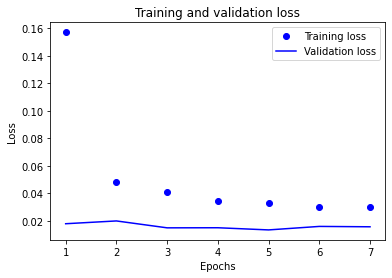

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#test set predictions
predictions_test = model.predict(x_test)
print(predictions_test)

[[0.81174576 0.729572  ]
 [0.783605   0.70397735]
 [0.7510061  0.67485523]
 ...
 [0.80956614 0.7267721 ]
 [0.8117459  0.72957206]
 [0.81352055 0.723455  ]]


In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.099
The Spearman's correlation coefficient is: 0.023


In [ ]:
y_test.shape

(650, 2)

In [ ]:
# Saving the model
model.save('/content/drive/MyDrive/ML Assignment/Trained_Models/InceptionV3_NN.h5')  # creates a HDF5 file 'my_model.h5'

## Aesthetics

In [ ]:
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
y = aesthetics[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arr_aesthetics, y, test_size=0.2, random_state=42)

In [ ]:
n_cols = x_train.shape[1]
n_cols

218

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Epoch 1/30
105/105 [==============================] - 1s 6ms/step - loss: 906.8740 - accuracy: 0.4928 - val_loss: 7.3312 - val_accuracy: 0.6229
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 78.4835 - accuracy: 0.4843 - val_loss: 3.5446 - val_accuracy: 0.5701
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 33.3082 - accuracy: 0.4678 - val_loss: 0.9724 - val_accuracy: 0.5924
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 9.6470 - accuracy: 0.4700 - val_loss: 0.7858 - val_accuracy: 0.5729
Epoch 5/30
105/105 [==============================] - 0s 2ms/step - loss: 10.1552 - accuracy: 0.5133 - val_loss: 0.8284 - val_accuracy: 0.6007
Epoch 6/30
105/105 [==============================] - 0s 2ms/step - loss: 4.4409 - accuracy: 0.5279 - val_loss: 0.8701 - val_accuracy: 0.6431


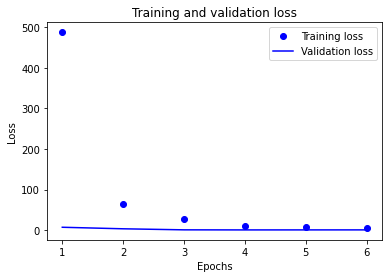

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#test set predictions
predictions_test = model.predict(x_test)
print(predictions_test)

[[-0.00308903  0.44256908]
 [ 0.2524665   0.16084741]
 [ 0.46107054  0.27058324]
 ...
 [ 0.34989014  0.09826875]
 [ 0.24295093  0.18214126]
 [ 0.3483007   0.20864114]]


In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: -0.034
The Spearman's correlation coefficient is: -0.027


In [ ]:
# Saving the model
model.save('/content/drive/MyDrive/ML Assignment/Trained_Models/Aesthetics_NN.h5')  # creates a HDF5 file 'my_model.h5'

## ColorHistogram

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 768))

for i in ch.index:
  ch['video-0'][i] = ch['video-0'][i][0] + ch['video-0'][i][1] + ch['video-0'][i][2]
  ch['video-56'][i] = ch['video-56'][i][0] + ch['video-56'][i][1] + ch['video-56'][i][2]
  ch['video-112'][i] = ch['video-112'][i][0] + ch['video-112'][i][1] + ch['video-112'][i][2]
  res = np.hstack((ch['video-0'][i], ch['video-56'][i], ch['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arr_ch = result_array
del result_array
print(type(X_arr_ch))
X_arr_ch

<class 'numpy.ndarray'>


array([[8.54550e+04, 1.74820e+04, 1.61940e+04, ..., 1.43900e+04,
        2.09500e+03, 3.16360e+04],
       [6.51922e+05, 2.05142e+05, 2.40695e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.56000e+02, 6.40000e+01, 9.30000e+01, ..., 1.02950e+04,
        1.99100e+03, 1.16530e+04],
       ...,
       [2.00000e+01, 7.00000e+00, 1.70000e+01, ..., 7.18000e+02,
        2.31000e+02, 1.67000e+02],
       [7.02000e+02, 2.59000e+02, 3.56000e+02, ..., 2.58900e+03,
        7.32000e+02, 1.39610e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.91000e+02,
        1.47000e+02, 8.82000e+02]])

In [ ]:
y = ch[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arr_ch, y, test_size=0.2, random_state=42)
n_cols = x_train.shape[1]
n_cols

768

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Epoch 1/30
64/64 [==============================] - 1s 6ms/step - loss: 2254417449.3538 - accuracy: 0.4744 - val_loss: 25778334.0000 - val_accuracy: 0.4014
Epoch 2/30
64/64 [==============================] - 0s 3ms/step - loss: 402422132.4308 - accuracy: 0.3322 - val_loss: 25167018.0000 - val_accuracy: 0.3352
Epoch 3/30
64/64 [==============================] - 0s 3ms/step - loss: 172329871.2385 - accuracy: 0.3453 - val_loss: 9316964.0000 - val_accuracy: 0.3216
Epoch 4/30
64/64 [==============================] - 0s 3ms/step - loss: 109155523.3522 - accuracy: 0.3274 - val_loss: 7744589.5000 - val_accuracy: 0.3101
Epoch 5/30
64/64 [==============================] - 0s 4ms/step - loss: 84294494.8923 - accuracy: 0.3105 - val_loss: 6106508.0000 - val_accuracy: 0.3158
Epoch 6/30
64/64 [==============================] - 0s 3ms/step - loss: 178140362.4615 - accuracy: 0.3275 - val_loss: 4182412.0000 - val_accuracy: 0.3261
Epoch 7/30
64/64 [==============================] - 0s 3ms/step - loss: 30

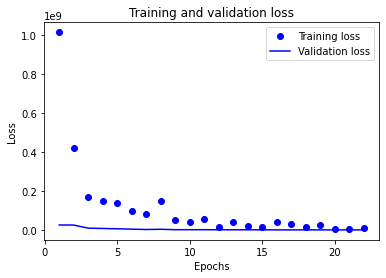

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#test set predictions
predictions_test = model.predict(x_test)
print(predictions_test)

[[-1.7617805e-02  8.2256505e-03]
 [-1.7617805e-02  8.2256505e-03]
 [-1.7617805e-02  8.2256505e-03]
 ...
 [-1.7617805e-02  8.2256505e-03]
 [-1.7617805e-02  8.2256505e-03]
 [-4.6696147e+03  2.9286653e+03]]


In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: -0.030
The Spearman's correlation coefficient is: -0.007


# Model 2: Support Vector Regressor implemented using Scikit-Learn

## Convolution 3D Feature

In [ ]:
## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
y_short = c3d[['short-term_memorability']].values
y_long = c3d[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrC3D,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrC3D,y_long,test_size=0.2,random_state=42)

Standardizing the input.
https://statisticsbyjim.com/regression/standardize-variables-regression/

In [ ]:
short_X = StandardScaler()
short_y = StandardScaler()
short_x_train = short_X.fit_transform(short_x_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_x_train = long_X.fit_transform(long_x_train)
long_y_train = long_y.fit_transform(long_y_train)

In [ ]:
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_x_train, short_y_train)
long_regressor.fit(long_x_train,long_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
short_pred = short_regressor.predict(short_x_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_x_test)
long_pred = long_y.inverse_transform(long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.207
The Spearman's correlation coefficient is: 0.075


## HMP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y_short = hmp[['short-term_memorability']].values
y_long = hmp[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrHMP,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrHMP,y_long,test_size=0.2,random_state=42)

In [ ]:
short_X = StandardScaler()
short_y = StandardScaler()
short_x_train = short_X.fit_transform(short_x_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_x_train = long_X.fit_transform(long_x_train)
long_y_train = long_y.fit_transform(long_y_train)

In [ ]:
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_x_train, short_y_train)
long_regressor.fit(long_x_train,long_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
short_pred = short_regressor.predict(short_x_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_x_test)
long_pred = long_y.inverse_transform(long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.145
The Spearman's correlation coefficient is: 0.063


## LBP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.00966435, 0.00291811, 0.00219425, ..., 0.00153356, 0.02053385,
        0.46106385],
       [0.01084008, 0.00189525, 0.00154128, ..., 0.00201196, 0.1233642 ,
        0.48225502],
       [0.01163436, 0.00431472, 0.00321277, ..., 0.00585455, 0.22441985,
        0.53576003],
       ...,
       [0.01986834, 0.00499807, 0.00462867, ..., 0.00459732, 0.02559655,
        0.77324701],
       [0.01122299, 0.00182677, 0.00189284, ..., 0.00292197, 0.03341098,
        0.53772618],
       [0.00933883, 0.00161941, 0.00137346, ..., 0.00222029, 0.03523389,
        0.49374518]])

In [ ]:
y_short = lbp[['short-term_memorability']].values
y_long = lbp[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrLBP,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrLBP,y_long,test_size=0.2,random_state=42)

In [ ]:
short_X = StandardScaler()
short_y = StandardScaler()
short_x_train = short_X.fit_transform(short_x_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_x_train = long_X.fit_transform(long_x_train)
long_y_train = long_y.fit_transform(long_y_train)

In [ ]:
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_x_train, short_y_train)
long_regressor.fit(long_x_train,long_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
short_pred = short_regressor.predict(short_x_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_x_test)
long_pred = long_y.inverse_transform(long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.211
The Spearman's correlation coefficient is: 0.074


## InceptionV3

In [ ]:
# Reusing same variable names to reduce memory.
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 3000))

for i in inceptionv3.index:
  while len(inceptionv3['video-0'][i]) < 1000:
    inceptionv3['video-0'][i] = np.append((inceptionv3['video-0'][i]), 0)
  while len(inceptionv3['video-56'][i]) < 1000:
    inceptionv3['video-56'][i] = np.append((inceptionv3['video-56'][i]), 0)
  while len(inceptionv3['video-112'][i]) < 1000:
    inceptionv3['video-112'][i] = np.append((inceptionv3['video-112'][i]), 0)
  res = np.hstack((inceptionv3['video-0'][i], inceptionv3['video-56'][i], inceptionv3['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_inception = result_array
del result_array
print(type(X_arr_inception))
X_arr_inception

<class 'numpy.ndarray'>


array([[2.926813e-18, 3.022254e-19, 4.139101e-19, ..., 3.913046e-23,
        2.295526e-20, 2.015046e-17],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.619819e-33, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.332495e-25, 2.549710e-34, 7.246693e-37, ..., 0.000000e+00,
        0.000000e+00, 6.700695e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [ ]:
y_short = inceptionv3[['short-term_memorability']].values
y_long = inceptionv3[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_inception,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_inception,y_long,test_size=0.2,random_state=42)

In [ ]:
short_X = StandardScaler()
short_y = StandardScaler()
short_x_train = short_X.fit_transform(short_x_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_x_train = long_X.fit_transform(long_x_train)
long_y_train = long_y.fit_transform(long_y_train)

In [ ]:
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_x_train, short_y_train)
long_regressor.fit(long_x_train,long_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
short_pred = short_regressor.predict(short_x_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_x_test)
long_pred = long_y.inverse_transform(long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.143
The Spearman's correlation coefficient is: 0.029


## Aesthetics

In [ ]:
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
aesthetics[['short-term_memorability']].values

array([[0.924],
       [0.923],
       [0.863],
       ...,
       [0.713],
       [0.954],
       [0.953]])

In [ ]:
y_short = aesthetics[['short-term_memorability']].values
y_long = aesthetics[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_aesthetics,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_aesthetics,y_long,test_size=0.2,random_state=42)

In [ ]:
short_X = StandardScaler()
short_y = StandardScaler()
short_x_train = short_X.fit_transform(short_x_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_x_train = long_X.fit_transform(long_x_train)
long_y_train = long_y.fit_transform(long_y_train)

In [ ]:
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_x_train, short_y_train.ravel())
long_regressor.fit(long_x_train,long_y_train.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
short_pred = short_regressor.predict(short_x_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_x_test)
long_pred = long_y.inverse_transform(long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: nan
The Spearman's correlation coefficient is: nan


## ColorHistogram

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 768))

for i in ch.index:
  ch['video-0'][i] = ch['video-0'][i][0] + ch['video-0'][i][1] + ch['video-0'][i][2]
  ch['video-56'][i] = ch['video-56'][i][0] + ch['video-56'][i][1] + ch['video-56'][i][2]
  ch['video-112'][i] = ch['video-112'][i][0] + ch['video-112'][i][1] + ch['video-112'][i][2]
  res = np.hstack((ch['video-0'][i], ch['video-56'][i], ch['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arr_ch = result_array
del result_array
print(type(X_arr_ch))
X_arr_ch

<class 'numpy.ndarray'>


array([[8.54550e+04, 1.74820e+04, 1.61940e+04, ..., 1.43900e+04,
        2.09500e+03, 3.16360e+04],
       [6.51922e+05, 2.05142e+05, 2.40695e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.56000e+02, 6.40000e+01, 9.30000e+01, ..., 1.02950e+04,
        1.99100e+03, 1.16530e+04],
       ...,
       [2.00000e+01, 7.00000e+00, 1.70000e+01, ..., 7.18000e+02,
        2.31000e+02, 1.67000e+02],
       [7.02000e+02, 2.59000e+02, 3.56000e+02, ..., 2.58900e+03,
        7.32000e+02, 1.39610e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.91000e+02,
        1.47000e+02, 8.82000e+02]])

In [ ]:
y_short = ch[['short-term_memorability']].values
y_long = ch[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_ch,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_ch,y_long,test_size=0.2,random_state=42)

In [ ]:
short_X = StandardScaler()
short_y = StandardScaler()
short_x_train = short_X.fit_transform(short_x_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_x_train = long_X.fit_transform(long_x_train)
long_y_train = long_y.fit_transform(long_y_train)

In [ ]:
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_x_train, short_y_train)
long_regressor.fit(long_x_train,long_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
short_pred = short_regressor.predict(short_x_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_x_test)
long_pred = long_y.inverse_transform(long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: nan
The Spearman's correlation coefficient is: nan


# Model 3: Random Forest Regressor with n-estimator = 100 using Scikit-Learn

## Convolution 3D Feature

In [ ]:
## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
y = c3d[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrC3D, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
c3d_pred = predictions_test
c3d_pred

array([[0.87748   , 0.7558325 ],
       [0.78574833, 0.66925   ],
       [0.86152   , 0.77589   ],
       ...,
       [0.8363    , 0.75413   ],
       [0.82682   , 0.69745   ],
       [0.8337325 , 0.74701   ]])

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.283
The Spearman's correlation coefficient is: 0.103


## HMP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y = hmp[['short-term_memorability','long-term_memorability']].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_arrHMP, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.259
The Spearman's correlation coefficient is: 0.100


## LBP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.00966435, 0.00291811, 0.00219425, ..., 0.00153356, 0.02053385,
        0.46106385],
       [0.01084008, 0.00189525, 0.00154128, ..., 0.00201196, 0.1233642 ,
        0.48225502],
       [0.01163436, 0.00431472, 0.00321277, ..., 0.00585455, 0.22441985,
        0.53576003],
       ...,
       [0.01986834, 0.00499807, 0.00462867, ..., 0.00459732, 0.02559655,
        0.77324701],
       [0.01122299, 0.00182677, 0.00189284, ..., 0.00292197, 0.03341098,
        0.53772618],
       [0.00933883, 0.00161941, 0.00137346, ..., 0.00222029, 0.03523389,
        0.49374518]])

In [ ]:
y = lbp[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrLBP, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.248
The Spearman's correlation coefficient is: 0.105


## InceptionV3

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 3000))

for i in inceptionv3.index:
  while len(inceptionv3['video-0'][i]) < 1000:
    inceptionv3['video-0'][i] = np.append((inceptionv3['video-0'][i]), 0)
  while len(inceptionv3['video-56'][i]) < 1000:
    inceptionv3['video-56'][i] = np.append((inceptionv3['video-56'][i]), 0)
  while len(inceptionv3['video-112'][i]) < 1000:
    inceptionv3['video-112'][i] = np.append((inceptionv3['video-112'][i]), 0)
  res = np.hstack((inceptionv3['video-0'][i], inceptionv3['video-56'][i], inceptionv3['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_inception = result_array
del result_array
print(type(X_arr_inception))
X_arr_inception

<class 'numpy.ndarray'>


array([[2.926813e-18, 3.022254e-19, 4.139101e-19, ..., 3.913046e-23,
        2.295526e-20, 2.015046e-17],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.619819e-33, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.332495e-25, 2.549710e-34, 7.246693e-37, ..., 0.000000e+00,
        0.000000e+00, 6.700695e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [ ]:
y = inceptionv3[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arr_inception, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.118
The Spearman's correlation coefficient is: 0.032


## Aesthetics

In [ ]:
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
y = aesthetics[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arr_aesthetics, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.285
The Spearman's correlation coefficient is: 0.116


## ColorHistogram

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 768))

for i in ch.index:
  ch['video-0'][i] = ch['video-0'][i][0] + ch['video-0'][i][1] + ch['video-0'][i][2]
  ch['video-56'][i] = ch['video-56'][i][0] + ch['video-56'][i][1] + ch['video-56'][i][2]
  ch['video-112'][i] = ch['video-112'][i][0] + ch['video-112'][i][1] + ch['video-112'][i][2]
  res = np.hstack((ch['video-0'][i], ch['video-56'][i], ch['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arr_ch = result_array
del result_array
print(type(X_arr_ch))
X_arr_ch

<class 'numpy.ndarray'>


array([[8.54550e+04, 1.74820e+04, 1.61940e+04, ..., 1.43900e+04,
        2.09500e+03, 3.16360e+04],
       [6.51922e+05, 2.05142e+05, 2.40695e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.56000e+02, 6.40000e+01, 9.30000e+01, ..., 1.02950e+04,
        1.99100e+03, 1.16530e+04],
       ...,
       [2.00000e+01, 7.00000e+00, 1.70000e+01, ..., 7.18000e+02,
        2.31000e+02, 1.67000e+02],
       [7.02000e+02, 2.59000e+02, 3.56000e+02, ..., 2.58900e+03,
        7.32000e+02, 1.39610e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.91000e+02,
        1.47000e+02, 8.82000e+02]])

In [ ]:
y = ch[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arr_ch, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.169
The Spearman's correlation coefficient is: 0.075


# Model 4: K-nearest neighbors using Scikit-Learn

## With n_neighbors=5

### Convolution 3D Feature

In [ ]:
## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
y = c3d[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrC3D, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.185
The Spearman's correlation coefficient is: 0.039


### HMP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y = hmp[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrHMP, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.215
The Spearman's correlation coefficient is: 0.045


### LBP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.00966435, 0.00291811, 0.00219425, ..., 0.00153356, 0.02053385,
        0.46106385],
       [0.01084008, 0.00189525, 0.00154128, ..., 0.00201196, 0.1233642 ,
        0.48225502],
       [0.01163436, 0.00431472, 0.00321277, ..., 0.00585455, 0.22441985,
        0.53576003],
       ...,
       [0.01986834, 0.00499807, 0.00462867, ..., 0.00459732, 0.02559655,
        0.77324701],
       [0.01122299, 0.00182677, 0.00189284, ..., 0.00292197, 0.03341098,
        0.53772618],
       [0.00933883, 0.00161941, 0.00137346, ..., 0.00222029, 0.03523389,
        0.49374518]])

In [ ]:
y = lbp[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrLBP, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.154
The Spearman's correlation coefficient is: 0.110


### InceptionV3

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 3000))

for i in inceptionv3.index:
  while len(inceptionv3['video-0'][i]) < 1000:
    inceptionv3['video-0'][i] = np.append((inceptionv3['video-0'][i]), 0)
  while len(inceptionv3['video-56'][i]) < 1000:
    inceptionv3['video-56'][i] = np.append((inceptionv3['video-56'][i]), 0)
  while len(inceptionv3['video-112'][i]) < 1000:
    inceptionv3['video-112'][i] = np.append((inceptionv3['video-112'][i]), 0)
  res = np.hstack((inceptionv3['video-0'][i], inceptionv3['video-56'][i], inceptionv3['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_inception = result_array
del result_array
print(type(X_arr_inception))
X_arr_inception

<class 'numpy.ndarray'>


array([[2.926813e-18, 3.022254e-19, 4.139101e-19, ..., 3.913046e-23,
        2.295526e-20, 2.015046e-17],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.619819e-33, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.332495e-25, 2.549710e-34, 7.246693e-37, ..., 0.000000e+00,
        0.000000e+00, 6.700695e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [ ]:
y = inceptionv3[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arr_inception, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.040
The Spearman's correlation coefficient is: 0.018


### Aesthetics

In [ ]:
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
y = aesthetics[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arr_aesthetics, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.100
The Spearman's correlation coefficient is: 0.027


### ColorHistogram

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 768))

for i in ch.index:
  ch['video-0'][i] = ch['video-0'][i][0] + ch['video-0'][i][1] + ch['video-0'][i][2]
  ch['video-56'][i] = ch['video-56'][i][0] + ch['video-56'][i][1] + ch['video-56'][i][2]
  ch['video-112'][i] = ch['video-112'][i][0] + ch['video-112'][i][1] + ch['video-112'][i][2]
  res = np.hstack((ch['video-0'][i], ch['video-56'][i], ch['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arr_ch = result_array
del result_array
print(type(X_arr_ch))
X_arr_ch

<class 'numpy.ndarray'>


array([[8.54550e+04, 1.74820e+04, 1.61940e+04, ..., 1.43900e+04,
        2.09500e+03, 3.16360e+04],
       [6.51922e+05, 2.05142e+05, 2.40695e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.56000e+02, 6.40000e+01, 9.30000e+01, ..., 1.02950e+04,
        1.99100e+03, 1.16530e+04],
       ...,
       [2.00000e+01, 7.00000e+00, 1.70000e+01, ..., 7.18000e+02,
        2.31000e+02, 1.67000e+02],
       [7.02000e+02, 2.59000e+02, 3.56000e+02, ..., 2.58900e+03,
        7.32000e+02, 1.39610e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.91000e+02,
        1.47000e+02, 8.82000e+02]])

In [ ]:
y = ch[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arr_ch, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.116
The Spearman's correlation coefficient is: 0.014


## Finding Optimum n_neighbors value by plotting graph

### Convolution 3D Feature

Minimum error:- 0.9808347529812607 at K = 0


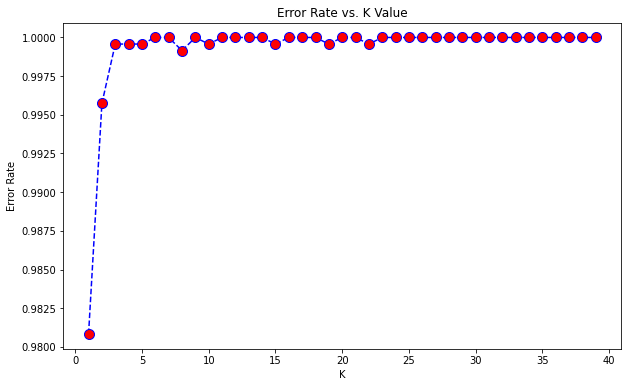

In [ ]:
error_rate = []
for i in range(1,40):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### HMP Feature

Minimum error:- 0.9758679085520745 at K = 0


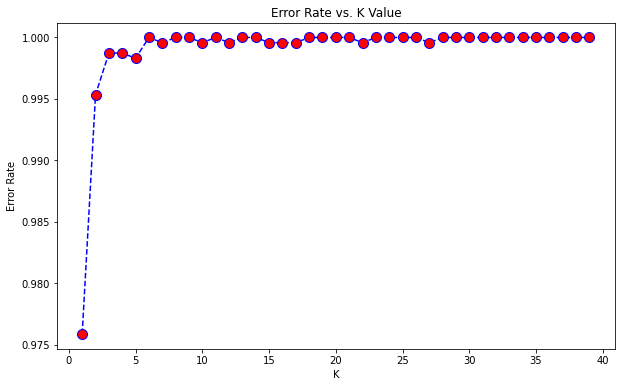

In [ ]:
error_rate = []
for i in range(1,40):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### LBP Feature

Minimum error:- 0.9805475504322767 at K = 0


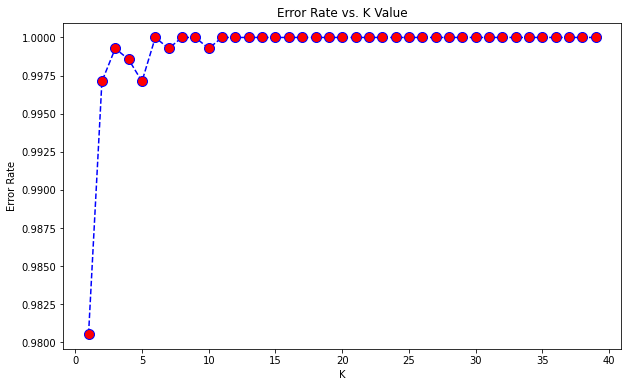

In [ ]:
error_rate = []
for i in range(1,40):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### InceptionV3

Minimum error:- 0.9815384615384616 at K = 0


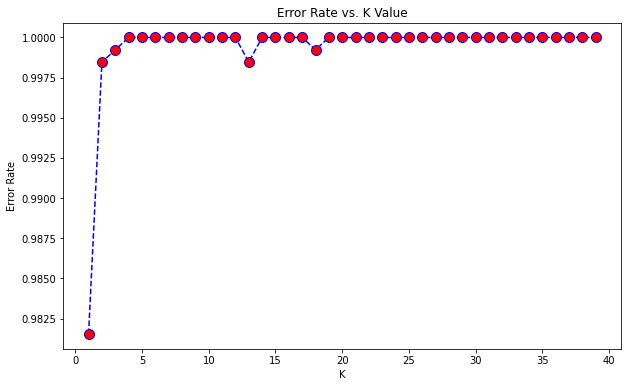

In [ ]:
error_rate = []
for i in range(1,40):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### Aesthetics

Minimum error:- 0.975 at K = 0


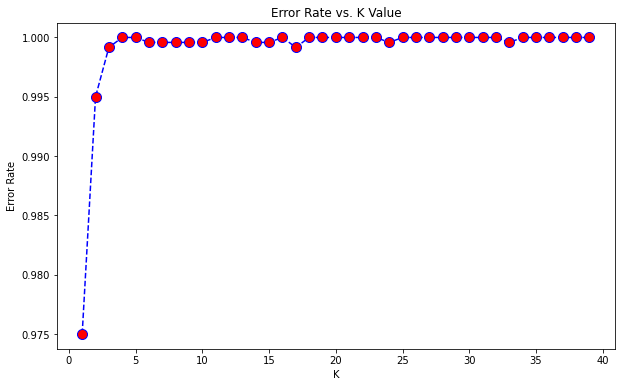

In [ ]:
error_rate = []
for i in range(1,40):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### ColorHistogram

Minimum error:- 0.9774281805745554 at K = 0


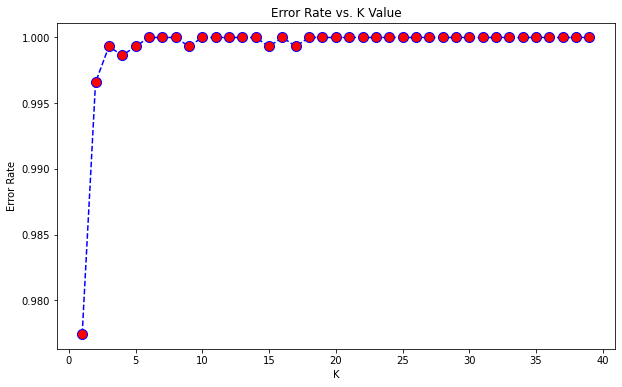

In [ ]:
error_rate = []
for i in range(1,40):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

## Training using Optimum n_neighbors Value

### Convolution 3D Feature

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.100
The Spearman's correlation coefficient is: -0.009


### HMP Feature

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.154
The Spearman's correlation coefficient is: 0.047


### LBP Feature

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.072
The Spearman's correlation coefficient is: 0.073


### InceptionV3

In [ ]:
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.097
The Spearman's correlation coefficient is: 0.022


### Aesthetics

In [ ]:
knn = KNeighborsRegressor(n_neighbors=50)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')

In [ ]:
predictions_test = knn.predict(x_test)

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.137
The Spearman's correlation coefficient is: 0.057


### ColorHistogram

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)
predictions_test = knn.predict(x_test)
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.116
The Spearman's correlation coefficient is: 0.014


NOTE: As the number of neighbors are growing the spearman coefficient is increasing. Check out InceptionV3

# Model 5: Extreme Gradient Boosting Algorithm using Scikit-Learn API

**NOTE:** n-estimator value for Extreme Gradient Boosting was found out by running the model for multiple values follow the hit and trial method

## Convolution 3D Feature

In [ ]:
## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
y_short = c3d[['short-term_memorability']].values
y_long = c3d[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrC3D,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrC3D,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=200)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[10:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.281
The Spearman's correlation coefficient is: 0.116


## HMP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y_short = hmp[['short-term_memorability']].values
y_long = hmp[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrHMP,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrHMP,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=200)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[10:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
long_pred.shape

(1181,)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.287
The Spearman's correlation coefficient is: 0.079


## LBP Feature

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.00966435, 0.00291811, 0.00219425, ..., 0.00153356, 0.02053385,
        0.46106385],
       [0.01084008, 0.00189525, 0.00154128, ..., 0.00201196, 0.1233642 ,
        0.48225502],
       [0.01163436, 0.00431472, 0.00321277, ..., 0.00585455, 0.22441985,
        0.53576003],
       ...,
       [0.01986834, 0.00499807, 0.00462867, ..., 0.00459732, 0.02559655,
        0.77324701],
       [0.01122299, 0.00182677, 0.00189284, ..., 0.00292197, 0.03341098,
        0.53772618],
       [0.00933883, 0.00161941, 0.00137346, ..., 0.00222029, 0.03523389,
        0.49374518]])

In [ ]:
y_short = lbp[['short-term_memorability']].values
y_long = lbp[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrLBP,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrLBP,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=200)
long_xgb = XGBRegressor(n_estimators=250)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[10:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.227
The Spearman's correlation coefficient is: 0.068


## InceptionV3

In [ ]:
# Reusing same variable names to reduce memory.
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 3000))

for i in inceptionv3.index:
  while len(inceptionv3['video-0'][i]) < 1000:
    inceptionv3['video-0'][i] = np.append((inceptionv3['video-0'][i]), 0)
  while len(inceptionv3['video-56'][i]) < 1000:
    inceptionv3['video-56'][i] = np.append((inceptionv3['video-56'][i]), 0)
  while len(inceptionv3['video-112'][i]) < 1000:
    inceptionv3['video-112'][i] = np.append((inceptionv3['video-112'][i]), 0)
  res = np.hstack((inceptionv3['video-0'][i], inceptionv3['video-56'][i], inceptionv3['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_inception = result_array
del result_array
print(type(X_arr_inception))
X_arr_inception

<class 'numpy.ndarray'>


array([[2.926813e-18, 3.022254e-19, 4.139101e-19, ..., 3.913046e-23,
        2.295526e-20, 2.015046e-17],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.619819e-33, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.332495e-25, 2.549710e-34, 7.246693e-37, ..., 0.000000e+00,
        0.000000e+00, 6.700695e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [ ]:
y_short = inceptionv3[['short-term_memorability']].values
y_long = inceptionv3[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_inception,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_inception,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=150)
long_xgb = XGBRegressor(n_estimators=250)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[09:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.198
The Spearman's correlation coefficient is: 0.086


## Aesthetics

In [ ]:
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
y_short = aesthetics[['short-term_memorability']].values
y_long = aesthetics[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_aesthetics,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_aesthetics,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=200)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[10:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.294
The Spearman's correlation coefficient is: 0.102


## ColorHistogram

In [ ]:
# Reusing same variable names to reduce memory.
result_array = np.empty((0, 768))

for i in ch.index:
  ch['video-0'][i] = ch['video-0'][i][0] + ch['video-0'][i][1] + ch['video-0'][i][2]
  ch['video-56'][i] = ch['video-56'][i][0] + ch['video-56'][i][1] + ch['video-56'][i][2]
  ch['video-112'][i] = ch['video-112'][i][0] + ch['video-112'][i][1] + ch['video-112'][i][2]
  res = np.hstack((ch['video-0'][i], ch['video-56'][i], ch['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arr_ch = result_array
del result_array
print(type(X_arr_ch))
X_arr_ch

<class 'numpy.ndarray'>


array([[8.54550e+04, 1.74820e+04, 1.61940e+04, ..., 1.43900e+04,
        2.09500e+03, 3.16360e+04],
       [6.51922e+05, 2.05142e+05, 2.40695e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.56000e+02, 6.40000e+01, 9.30000e+01, ..., 1.02950e+04,
        1.99100e+03, 1.16530e+04],
       ...,
       [2.00000e+01, 7.00000e+00, 1.70000e+01, ..., 7.18000e+02,
        2.31000e+02, 1.67000e+02],
       [7.02000e+02, 2.59000e+02, 3.56000e+02, ..., 2.58900e+03,
        7.32000e+02, 1.39610e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.91000e+02,
        1.47000e+02, 8.82000e+02]])

In [ ]:
y_short = ch[['short-term_memorability']].values
y_long = ch[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_ch,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_ch,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=200)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[11:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.096
The Spearman's correlation coefficient is: 0.047


# Weighted Average Ensembling

**NOTE:** The initial idea for weighted Average ensembling was to drop the missing columns from every feature and get the all the features with common video names. By doing so the I observed that the spearman coefficient drastically decreased. 

Therefore, I dropped this plan and filled the missing values with list of "0" of appropriate length for each feature

## Creating Feature with common video names

There are missing values for each of these videos. Therefore, creating a new dataframe with only the video names for which the values are available is important for further ensembling technique.

In [ ]:
c3d_video_names = c3d.index
inception_video_names = inceptionv3.index
hmp_video_names = hmp.index
lbp_video_names = lbp.index

In [ ]:
## Selecting the intersection of these lists
video_names = set(c3d_video_names) & set(inception_video_names) & set(hmp_video_names) & set(lbp_video_names)

In [ ]:
len(video_names)

3018

### Selecting predictions "y" for these videos

In [ ]:
df_y = c3d.loc[list(video_names)]
y = df_y[['short-term_memorability','long-term_memorability']].values

### Training C3D using Random Forest

In [ ]:
## Creating dataframes with these indexes

## Length of C3D feature is 101
result_array = np.empty((0, 101))
for index in c3d.index:
  if index in video_names:
    result_array = np.append(result_array, np.array([c3d['c3d'][index]]), axis = 0)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       [6.3948100e-03, 7.3140900e-03, 2.2434700e-03, ..., 1.5610234e-01,
        3.4805939e-01, 3.8712620e-02],
       [1.4891000e-04, 5.6307000e-04, 7.8970000e-05, ..., 5.7000000e-06,
        3.3100000e-06, 4.9986460e-02],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrC3D, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
c3d_pred = predictions_test
c3d_pred

array([[0.86019, 0.79031],
       [0.85846, 0.75343],
       [0.85243, 0.7747 ],
       ...,
       [0.86391, 0.76027],
       [0.84443, 0.72498],
       [0.86901, 0.80281]])

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: -0.002
The Spearman's correlation coefficient is: -0.081


**Dropping this approach as it is giving bad score**

# Training best performing models without ignoring missing values

## Random Forest on C3D

In [ ]:
c3d = pd.read_pickle('/content/drive/MyDrive/ML Assignment/c3d')


## Relacing missing values with list of 101 zeros.
for i in c3d.index:
  if isinstance(c3d['c3d'][i],int):
    c3d['c3d'][i] = [0] * 101    



## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
y = c3d[['short-term_memorability','long-term_memorability']].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_arrC3D, y, test_size=0.2,random_state=42)

In [ ]:
print("Train set has total {0}".format(len(x_train)))
print("Test set has total {0}".format(len(x_test)))
print("Y_Test set has total {0}".format(len(y_test)))
print("Y_Train set has total {0}".format(len(y_train)))

Train set has total 4800
Test set has total 1200
Y_Test set has total 1200
Y_Train set has total 4800


In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)

In [ ]:
y_test.shape

(1200, 2)

In [ ]:
c3d_pred = predictions_test
c3d_pred

array([[0.89221 , 0.78328 ],
       [0.84366 , 0.73867 ],
       [0.87946 , 0.78075 ],
       ...,
       [0.88292 , 0.78    ],
       [0.910298, 0.85297 ],
       [0.87488 , 0.82443 ]])

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.324
The Spearman's correlation coefficient is: 0.106


In [ ]:
## Saving the predictions to local for future ensemble
save('/content/drive/MyDrive/ML Assignment/Predictions/c3d_pred_RF.npy', c3d_pred)

## Random Forest on LBP

In [ ]:
lbp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/lbp')

In [ ]:
## Relacing missing values with list of 122 zeros.
for i in lbp.index:
  if isinstance(lbp['video-0'][i],int):
    lbp['video-0'][i] = [0] * 122
  if isinstance(lbp['video-56'][i],int):
    lbp['video-56'][i] = [0] * 122
  if isinstance(lbp['video-112'][i],int):
    lbp['video-112'][i] = [0] * 122


result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: Sett

In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00966435, 0.00291811, 0.00219425, ..., 0.00153356, 0.02053385,
        0.46106385],
       [0.01084008, 0.00189525, 0.00154128, ..., 0.00201196, 0.1233642 ,
        0.48225502],
       ...,
       [0.01986834, 0.00499807, 0.00462867, ..., 0.00459732, 0.02559655,
        0.77324701],
       [0.01122299, 0.00182677, 0.00189284, ..., 0.00292197, 0.03341098,
        0.53772618],
       [0.00933883, 0.00161941, 0.00137346, ..., 0.00222029, 0.03523389,
        0.49374518]])

In [ ]:
y = lbp[['short-term_memorability','long-term_memorability']].values
x_train, x_test, y_train, y_test = train_test_split(X_arrLBP, y, test_size=0.2,random_state=42)

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
predictions_test = random_forest.predict(x_test)
lbp_pred = predictions_test
lbp_pred

array([[0.86242914, 0.78330989],
       [0.86713   , 0.78965   ],
       [0.86242914, 0.78330989],
       ...,
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989]])

In [ ]:
Get_score(predictions_test, y_test)

The Spearman's correlation coefficient is: 0.255
The Spearman's correlation coefficient is: 0.050


In [ ]:
save('/content/drive/MyDrive/ML Assignment/Predictions/lbp_pred_RF.npy', lbp_pred)

## XGBoost on HMP

In [ ]:
hmp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/hmp')

In [ ]:
for i in hmp.index:
  if isinstance(hmp['hmp'][i],int):
    hmp['hmp'][i] = [0] * 6075


# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y_short = hmp[['short-term_memorability']].values
y_long = hmp[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arrHMP,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arrHMP,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=150)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[20:52:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
save('/content/drive/MyDrive/ML Assignment/Predictions/hmp_short_pred_XGB.npy', short_pred)
save('/content/drive/MyDrive/ML Assignment/Predictions/hmp_long_pred_XGB.npy', long_pred)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.317
The Spearman's correlation coefficient is: 0.121


## XGBoost on InceptionV3

In [ ]:
inceptionv3 = pd.read_pickle('/content/drive/MyDrive/ML Assignment/inception_v3')

for i in inceptionv3.index:
  if isinstance(inceptionv3['video-0'][i],int):
    inceptionv3['video-0'][i] = [0] * 1000
  if isinstance(inceptionv3['video-56'][i],int):
    inceptionv3['video-56'][i] = [0] * 1000
  if isinstance(inceptionv3['video-112'][i],int):
    inceptionv3['video-112'][i] = [0] * 1000



result_array = np.empty((0, 3000))

for i in inceptionv3.index:
  while len(inceptionv3['video-0'][i]) < 1000:
    inceptionv3['video-0'][i] = np.append((inceptionv3['video-0'][i]), 0)
  while len(inceptionv3['video-56'][i]) < 1000:
    inceptionv3['video-56'][i] = np.append((inceptionv3['video-56'][i]), 0)
  while len(inceptionv3['video-112'][i]) < 1000:
    inceptionv3['video-112'][i] = np.append((inceptionv3['video-112'][i]), 0)
  res = np.hstack((inceptionv3['video-0'][i], inceptionv3['video-56'][i], inceptionv3['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
X_arr_inception = result_array
del result_array
print(type(X_arr_inception))
X_arr_inception

<class 'numpy.ndarray'>


array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.926813e-18, 3.022254e-19, 4.139101e-19, ..., 3.913046e-23,
        2.295526e-20, 2.015046e-17],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.332495e-25, 2.549710e-34, 7.246693e-37, ..., 0.000000e+00,
        0.000000e+00, 6.700695e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [ ]:
y_short = inceptionv3[['short-term_memorability']].values
y_long = inceptionv3[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_inception,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_inception,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=150)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[21:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.156
The Spearman's correlation coefficient is: 0.040


In [ ]:
save('/content/drive/MyDrive/ML Assignment/Predictions/IV3_short_pred_XGB.npy', short_pred)
save('/content/drive/MyDrive/ML Assignment/Predictions/IV3_long_pred_XGB.npy', long_pred)

## XGBoost on Aesthetics

In [ ]:
aesthetics = pd.read_pickle('/content/drive/MyDrive/ML Assignment/aesthetic_feature')
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
y_short = aesthetics[['short-term_memorability']].values
y_long = aesthetics[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_aesthetics,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_aesthetics,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=200)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[21:11:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.294
The Spearman's correlation coefficient is: 0.102


In [ ]:
save('/content/drive/MyDrive/ML Assignment/Predictions/aesthetics_short_pred_XGB.npy', short_pred)
save('/content/drive/MyDrive/ML Assignment/Predictions/aesthetics_long_pred_XGB.npy', long_pred)

## XGBoost on ColorHistogram

In [ ]:
ch = pd.read_pickle('/content/drive/MyDrive/ML Assignment/color_histogram')

# Reusing same variable names to reduce memory.
result_array = np.empty((0, 768))

for i in ch.index:
  if isinstance(ch['video-0'][i],int):
    ch['video-0'][i] = [0] * 256
  else:
    ch['video-0'][i] = ch['video-0'][i][0] + ch['video-0'][i][1] + ch['video-0'][i][2]
  
  if isinstance(ch['video-56'][i],int):
    ch['video-56'][i] = [0] * 256
  else:
    ch['video-56'][i] = ch['video-56'][i][0] + ch['video-56'][i][1] + ch['video-56'][i][2]
  
  if isinstance(ch['video-112'][i],int):
    ch['video-112'][i] = [0] * 256
  else:
    ch['video-112'][i] = ch['video-112'][i][0] + ch['video-112'][i][1] + ch['video-112'][i][2]

  res = np.hstack((ch['video-0'][i], ch['video-56'][i], ch['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A 

In [ ]:
X_arr_ch = result_array
del result_array
print(type(X_arr_ch))
X_arr_ch

<class 'numpy.ndarray'>


array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.54550e+04, 1.74820e+04, 1.61940e+04, ..., 1.43900e+04,
        2.09500e+03, 3.16360e+04],
       [6.51922e+05, 2.05142e+05, 2.40695e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.00000e+01, 7.00000e+00, 1.70000e+01, ..., 7.18000e+02,
        2.31000e+02, 1.67000e+02],
       [7.02000e+02, 2.59000e+02, 3.56000e+02, ..., 2.58900e+03,
        7.32000e+02, 1.39610e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.91000e+02,
        1.47000e+02, 8.82000e+02]])

In [ ]:
y_short = ch[['short-term_memorability']].values
y_long = ch[['long-term_memorability']].values

In [ ]:
# Splitting the dataset into the Training set and Test set
short_x_train,short_x_test,short_y_train,short_y_test = train_test_split(X_arr_inception,y_short,test_size=0.2,random_state=42)
long_x_train,long_x_test,long_y_train,long_y_test = train_test_split(X_arr_inception,y_long,test_size=0.2,random_state=42)

In [ ]:
short_xgb = XGBRegressor(n_estimators=150)
long_xgb = XGBRegressor(n_estimators=200)
short_xgb.fit(short_x_train, short_y_train)
long_xgb.fit(long_x_train,long_y_train)

[21:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
short_pred = short_xgb.predict(short_x_test)
long_pred = long_xgb.predict(long_x_test)

In [ ]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.156
The Spearman's correlation coefficient is: 0.040


In [ ]:
save('/content/drive/MyDrive/ML Assignment/Predictions/color_histogram_short_pred_XGB.npy', short_pred)
save('/content/drive/MyDrive/ML Assignment/Predictions/color_histogram_long_pred_XGB.npy', long_pred)

# Weighted Average Ensembling

In [ ]:
## Assigning y_test 
ch = pd.read_pickle('/content/drive/MyDrive/ML Assignment/color_histogram')
y = ch[['short-term_memorability','long-term_memorability']].values
y_train, y_test = train_test_split(y, test_size=0.2,random_state=42)


## Loading saved predictions
IV3_short_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/IV3_short_pred_XGB.npy')
IV3_long_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/IV3_long_pred_XGB.npy')
hmp_short_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/hmp_short_pred_XGB.npy')
hmp_long_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/hmp_long_pred_XGB.npy')
lbp_pred_RF = load('/content/drive/MyDrive/ML Assignment/Predictions/lbp_pred_RF.npy')
c3d_pred_RF = load('/content/drive/MyDrive/ML Assignment/Predictions/c3d_pred_RF.npy')
color_histogram_short_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/color_histogram_short_pred_XGB.npy')
color_histogram_long_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/color_histogram_long_pred_XGB.npy')
aesthetics_short_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/aesthetics_short_pred_XGB.npy')
aesthetics_long_pred_XGB = load('/content/drive/MyDrive/ML Assignment/Predictions/aesthetics_long_pred_XGB.npy')

print("Shape of IV3_short_pred_XGB is =", IV3_short_pred_XGB.shape)
print("Shape of IV3_long_pred_XGB is =", IV3_long_pred_XGB.shape)
print("Shape of hmp_short_pred_XGB is =", hmp_short_pred_XGB.shape)
print("Shape of hmp_long_pred_XGB is =", hmp_long_pred_XGB.shape)
print("Shape of lbp_pred_RF is =", lbp_pred_RF.shape)
print("Shape of c3d_pred_RF is =", c3d_pred_RF.shape)
print("Shape of color_histogram_short_pred_XGB is =", color_histogram_short_pred_XGB.shape)
print("Shape of color_histogram_long_pred_XGB is =", color_histogram_long_pred_XGB.shape)
print("Shape of aesthetics_short_pred_XGB is =", aesthetics_short_pred_XGB.shape)
print("Shape of aesthetics_long_pred_XGB is =", aesthetics_long_pred_XGB.shape)
print()
print()

## Coverting XGB oost predictions to the same shape as others
print("Converting HMP Predictions to share (1200,2)...")
hmp_pred = np.column_stack((hmp_short_pred_XGB, hmp_long_pred_XGB))
print("Shape of HMP Prediction now is =", hmp_pred.shape)

print()

print("Converting Inception V3 Predictions to share (1200,2)...")
iv3_pred = np.column_stack((IV3_short_pred_XGB, IV3_long_pred_XGB))
print("Shape of Inception V3 Prediction now is =", iv3_pred.shape)

print()

print("Converting Aesthetics Predictions to share (1200,2)...")
aesthetics_pred = np.column_stack((aesthetics_short_pred_XGB, aesthetics_long_pred_XGB))
print("Shape of Aesthetics Prediction now is =", iv3_pred.shape)

print()

print("Converting Color Histogram Predictions to share (1200,2)...")
ch_pred = np.column_stack((color_histogram_short_pred_XGB, color_histogram_long_pred_XGB))
print("Shape of Color Histogram Prediction now is =", iv3_pred.shape)


Shape of IV3_short_pred_XGB is = (1200,)
Shape of IV3_long_pred_XGB is = (1200,)
Shape of hmp_short_pred_XGB is = (1200,)
Shape of hmp_long_pred_XGB is = (1200,)
Shape of lbp_pred_RF is = (1200, 2)
Shape of c3d_pred_RF is = (1200, 2)
Shape of color_histogram_short_pred_XGB is = (1200,)
Shape of color_histogram_long_pred_XGB is = (1200,)
Shape of aesthetics_short_pred_XGB is = (1200,)
Shape of aesthetics_long_pred_XGB is = (1200,)


Converting HMP Predictions to share (1200,2)...
Shape of HMP Prediction now is = (1200, 2)

Converting Inception V3 Predictions to share (1200,2)...
Shape of Inception V3 Prediction now is = (1200, 2)

Converting Aesthetics Predictions to share (1200,2)...
Shape of Aesthetics Prediction now is = (1200, 2)

Converting Color Histogram Predictions to share (1200,2)...
Shape of Color Histogram Prediction now is = (1200, 2)


**Tweaked the Get_score function to accomodate it with find_appropriate_weight function**

In [ ]:
def Get_score_updated(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            # print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
            results.append(score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score_updated(Y_pred[:,ii],Y_true[:,ii])
    return results

**find_appropriate_weight function follows hit and trial method to find the optimum weights to be used for the input feature list to get the best spearman coefficient.**

In [ ]:
def find_appropriate_weight(predictions, true):

  # Creating a list of permutations of input predictions
  predictions_permutation = list(itertools.permutations(predictions))

  # Pointer to get best Short term score
  best_score = 0
  best_result = []

  # Pointers for weights and corresponding features.
  final_weights = []
  final_features = []
  
  # Creating list with weights from 0.10 to 0.99
  weights_list = [i for i in range(10, 100, 1)]
  weights_list = [x / 100 for x in weights_list]

  # Getting all the combinations of weights with length equal to length of input prections
  weights_list = list(itertools.combinations(weights_list, len(predictions)))
  weights_list_combination = []

  # Keeping the combinations where the sum is equal to 1.
  for i in weights_list:
    if sum(i) == 1.0:
      weights_list_combination.append(i)

  # Ensembling with all combinations
  for i in predictions_permutation:
    for j in weights_list_combination:
      summ = np.empty(predictions_permutation[0][0].shape)
      for k in range(len(predictions)):
        summ += np.multiply(np.array(i)[k], np.array(j)[k])
      global results
      results = []
      temp = Get_score_updated(summ, true)
      del results
      if temp[0] > best_score:
        best_score = temp[0]
        best_result = temp
      final_weights = list(j)
      final_features = list(i)
  
  return (best_result, final_weights, final_features)

## Ensembling the 4 features (C3D, LBP, HMP, IV3)

In [ ]:
predictions = [lbp_pred_RF, c3d_pred_RF, hmp_pred, iv3_pred]
best_result, final_weights, final_features = find_appropriate_weight(predictions, y_test)

In [ ]:
print("Best results are :", best_result)
print()
print("Best weights are :", final_weights)
print()
print("Final Features :", final_features)
print()

Best results are : [0.34520668028464035, 0.024235957452438107]

Best weights are : [0.23, 0.24, 0.26, 0.27]

Final Features : [array([[0.8628242 , 0.7837635 ],
       [0.853126  , 0.7930182 ],
       [0.8628242 , 0.7837635 ],
       ...,
       [0.8628242 , 0.7837635 ],
       [0.8767178 , 0.85061413],
       [0.8628242 , 0.7837635 ]], dtype=float32), array([[0.8893162 , 0.77821195],
       [0.8532839 , 0.7953186 ],
       [0.8819634 , 0.8046951 ],
       ...,
       [0.8931877 , 0.7826072 ],
       [0.8903656 , 0.79383165],
       [0.877746  , 0.7910184 ]], dtype=float32), array([[0.89221 , 0.78328 ],
       [0.84366 , 0.73867 ],
       [0.87946 , 0.78075 ],
       ...,
       [0.88292 , 0.78    ],
       [0.910298, 0.85297 ],
       [0.87488 , 0.82443 ]]), array([[0.86242914, 0.78330989],
       [0.86713   , 0.78965   ],
       [0.86242914, 0.78330989],
       ...,
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989]])]



## Ensembling 2 features (C3D & HMP)

In [ ]:
predictions = [c3d_pred_RF, hmp_pred]
best_result, final_weights, final_features = find_appropriate_weight(predictions, y_test)
print("Best results are :", best_result)
print()
print("Best weights are :", final_weights)
print()
print("Final Features :", final_features)
print()

Best results are : [0.3443432978165853, 0.029009474033079775]

Best weights are : [0.49, 0.51]

Final Features : [array([[0.8893162 , 0.77821195],
       [0.8532839 , 0.7953186 ],
       [0.8819634 , 0.8046951 ],
       ...,
       [0.8931877 , 0.7826072 ],
       [0.8903656 , 0.79383165],
       [0.877746  , 0.7910184 ]], dtype=float32), array([[0.89221 , 0.78328 ],
       [0.84366 , 0.73867 ],
       [0.87946 , 0.78075 ],
       ...,
       [0.88292 , 0.78    ],
       [0.910298, 0.85297 ],
       [0.87488 , 0.82443 ]])]



## Ensemblin 3 Features (C3D, HMP, & LBP)

In [ ]:
predictions = [c3d_pred_RF, hmp_pred, lbp_pred_RF]
best_result, final_weights, final_features = find_appropriate_weight(predictions, y_test)
print("Best results are :", best_result)
print()
print("Best weights are :", final_weights)
print()
print("Final Features :", final_features)
print()

Best results are : [0.3454376100934223, 0.02615837727261591]

Best weights are : [0.32, 0.33, 0.35]

Final Features : [array([[0.86242914, 0.78330989],
       [0.86713   , 0.78965   ],
       [0.86242914, 0.78330989],
       ...,
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989]]), array([[0.8893162 , 0.77821195],
       [0.8532839 , 0.7953186 ],
       [0.8819634 , 0.8046951 ],
       ...,
       [0.8931877 , 0.7826072 ],
       [0.8903656 , 0.79383165],
       [0.877746  , 0.7910184 ]], dtype=float32), array([[0.89221 , 0.78328 ],
       [0.84366 , 0.73867 ],
       [0.87946 , 0.78075 ],
       ...,
       [0.88292 , 0.78    ],
       [0.910298, 0.85297 ],
       [0.87488 , 0.82443 ]])]



## Ensembling 3 best perfroming models (C3D, HMP, Aesthetics)

In [ ]:
predictions = [c3d_pred_RF, hmp_pred, aesthetics_pred]
best_result, final_weights, final_features = find_appropriate_weight(predictions, y_test)
print("Best results are :", best_result)
print()
print("Best weights are :", final_weights)
print()
print("Final Features :", final_features)
print()

Best results are : [0.3456971769485927, 0.028349494681350052]

Best weights are : [0.32, 0.33, 0.35]

Final Features : [array([[0.8814357 , 0.8358618 ],
       [0.78449804, 0.74279517],
       [0.8845825 , 0.81615466],
       ...,
       [0.8648213 , 0.757097  ],
       [0.86922324, 0.7260919 ],
       [0.85038483, 0.7568128 ]], dtype=float32), array([[0.8893162 , 0.77821195],
       [0.8532839 , 0.7953186 ],
       [0.8819634 , 0.8046951 ],
       ...,
       [0.8931877 , 0.7826072 ],
       [0.8903656 , 0.79383165],
       [0.877746  , 0.7910184 ]], dtype=float32), array([[0.89221 , 0.78328 ],
       [0.84366 , 0.73867 ],
       [0.87946 , 0.78075 ],
       ...,
       [0.88292 , 0.78    ],
       [0.910298, 0.85297 ],
       [0.87488 , 0.82443 ]])]



## Ensembling 4 features (C3D, HMP, LBP, Aesthetics)

In [ ]:
predictions = [c3d_pred_RF, hmp_pred, lbp_pred_RF, aesthetics_pred]
best_result, final_weights, final_features = find_appropriate_weight(predictions, y_test)
print("Best results are :", best_result)
print()
print("Best weights are :", final_weights)
print()
print("Final Features :", final_features)
print()

Best results are : [0.34622329716764394, 0.02687530495901011]

Best weights are : [0.23, 0.24, 0.26, 0.27]

Final Features : [array([[0.8814357 , 0.8358618 ],
       [0.78449804, 0.74279517],
       [0.8845825 , 0.81615466],
       ...,
       [0.8648213 , 0.757097  ],
       [0.86922324, 0.7260919 ],
       [0.85038483, 0.7568128 ]], dtype=float32), array([[0.86242914, 0.78330989],
       [0.86713   , 0.78965   ],
       [0.86242914, 0.78330989],
       ...,
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989],
       [0.86242914, 0.78330989]]), array([[0.8893162 , 0.77821195],
       [0.8532839 , 0.7953186 ],
       [0.8819634 , 0.8046951 ],
       ...,
       [0.8931877 , 0.7826072 ],
       [0.8903656 , 0.79383165],
       [0.877746  , 0.7910184 ]], dtype=float32), array([[0.89221 , 0.78328 ],
       [0.84366 , 0.73867 ],
       [0.87946 , 0.78075 ],
       ...,
       [0.88292 , 0.78    ],
       [0.910298, 0.85297 ],
       [0.87488 , 0.82443 ]])]



In [ ]:
# [aesthetics_pred, lbp_pred_RF, hmp_pred, c3d_pred_RF]

NOTE: Finally, I can conclude that the best performing models are as follows:

**For Short-term**: Ensemble of the below models

Feature--------Model---------------Weight

Aesthetics-----XGBoost-------------0.23

LBP------------RandomForest-------0.24

HMP------------XGBoost------------0.26

C3D------------RandomFOrest-------0.27

**For Long Term**: XGBoost on HMP

# Train Final model on full DEV Set

## For short-term memorability

### XGBoost on Aesthetics Feature

In [ ]:
aesthetics = pd.read_pickle('/content/drive/MyDrive/ML Assignment/aesthetic_feature')
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.18389 ,  0.713733,  0.202302, ...,  0.129661,  0.412381,
         0.788761],
       [ 0.147255,  0.550718,  0.460299, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063933,  0.826933,  0.214129, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.178087,  0.220956,  0.671676, ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113677,  0.585402,  0.496425, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554591,  0.134659,  0.691026, ...,  0.783961,  0.621886,
        -0.569049]])

In [ ]:
y_short = aesthetics[['short-term_memorability']].values
aesthetics_short_xgb = XGBRegressor(n_estimators=200)
aesthetics_short_xgb.fit(X_arr_aesthetics, y_short)

[23:21:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### XGBoost on HMP

In [ ]:
hmp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/hmp')

for i in hmp.index:
  if isinstance(hmp['hmp'][i],int):
    hmp['hmp'][i] = [0] * 6075


# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y_short = hmp[['short-term_memorability']].values
hmp_short_xgb = XGBRegressor(n_estimators=150)
hmp_short_xgb.fit(X_arrHMP, y_short)

[23:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### Random Forest on LBP

In [ ]:
lbp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/lbp')

## Relacing missing values with list of 122 zeros.
for i in lbp.index:
  if isinstance(lbp['video-0'][i],int):
    lbp['video-0'][i] = [0] * 122
  if isinstance(lbp['video-56'][i],int):
    lbp['video-56'][i] = [0] * 122
  if isinstance(lbp['video-112'][i],int):
    lbp['video-112'][i] = [0] * 122


result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launc

In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00966435, 0.00291811, 0.00219425, ..., 0.00153356, 0.02053385,
        0.46106385],
       [0.01084008, 0.00189525, 0.00154128, ..., 0.00201196, 0.1233642 ,
        0.48225502],
       ...,
       [0.01986834, 0.00499807, 0.00462867, ..., 0.00459732, 0.02559655,
        0.77324701],
       [0.01122299, 0.00182677, 0.00189284, ..., 0.00292197, 0.03341098,
        0.53772618],
       [0.00933883, 0.00161941, 0.00137346, ..., 0.00222029, 0.03523389,
        0.49374518]])

In [ ]:
y = lbp[['short-term_memorability','long-term_memorability']].values
lbp_random_forest = RandomForestRegressor(n_estimators=100)
lbp_random_forest.fit(X_arrLBP, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Random Forest on C3D

In [ ]:
c3d = pd.read_pickle('/content/drive/MyDrive/ML Assignment/c3d')


## Relacing missing values with list of 101 zeros.
for i in c3d.index:
  if isinstance(c3d['c3d'][i],int):
    c3d['c3d'][i] = [0] * 101    



## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[2.0249420e-02, 1.5778000e-03, 8.2625000e-04, ..., 3.3907000e-04,
        8.4368300e-03, 4.7004000e-04],
       [1.1800000e-04, 8.9075000e-04, 1.8769000e-04, ..., 1.5891000e-04,
        1.0252100e-03, 2.0460000e-05],
       [1.1765220e-02, 7.4577000e-04, 7.8353000e-04, ..., 5.3803300e-03,
        1.0274800e-03, 1.3844800e-03],
       ...,
       [2.5890000e-05, 1.2192000e-04, 2.7810000e-05, ..., 7.1593200e-03,
        4.9575200e-03, 8.9156000e-04],
       [2.6509121e-01, 9.6539180e-02, 5.9710000e-05, ..., 1.0834000e-04,
        1.2682000e-03, 7.1027000e-04],
       [2.0589490e-02, 1.2214100e-03, 2.0660700e-03, ..., 8.2839000e-04,
        4.9012800e-03, 1.1848300e-03]])

In [ ]:
y = c3d[['short-term_memorability','long-term_memorability']].values
c3d_random_forest = RandomForestRegressor(n_estimators=100)
c3d_random_forest.fit(X_arrC3D, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## For long-term memorability

### XGBoost on HMP

In [ ]:
hmp = pd.read_pickle('/content/drive/MyDrive/ML Assignment/hmp')

for i in hmp.index:
  if isinstance(hmp['hmp'][i],int):
    hmp['hmp'][i] = [0] * 6075


# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.31390e-02, 7.43500e-03, 3.22000e-04, ..., 7.56000e-04,
        7.38000e-04, 2.14000e-04],
       [1.49000e-02, 4.60700e-03, 9.90000e-05, ..., 6.40000e-05,
        6.40000e-05, 1.10000e-05],
       [4.15920e-02, 1.30470e-02, 4.48000e-04, ..., 2.89000e-04,
        9.88000e-04, 1.61000e-04]])

In [ ]:
y_long = hmp[['long-term_memorability']].values
hmp_long_xgb = XGBRegressor(n_estimators=200)
hmp_long_xgb.fit(X_arrHMP,y_long)

[23:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# Predicting on Test set

## Short-Term memorability

### Aesthetics Feature

In [ ]:
## Calling the method for fetching Aesthetic features and storing them into a array list using loop
## For Mean Values
my_numlist= [] # Creating new list to store the Aesthetic features
my_namelist = [] # Creating a new list to store the names of the videos
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/aesthetic_vis_features_test/mean/*.txt'):
    s= read_aesthetic_features(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('/')[-1]).split('.')[0]))

asf1 = pd.DataFrame(list(zip(my_namelist, my_numlist)),
               columns =['Name', 'aesthetic_feat_dev-set_mean'])

In [ ]:
##For Median Values
my_numlist= [] # Creating new list to store the Aesthetic features
my_namelist = [] 
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/aesthetic_vis_features_test/median/*.txt'):
    s= read_aesthetic_features(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('/')[-1]).split('.')[0]))

asf2 = pd.DataFrame(list(zip(my_namelist, my_numlist)),
               columns =['Name', 'aesthetic_feat_dev-set_median'])

In [ ]:
asf = asf1.merge(asf2, on='Name')

In [ ]:
asf.head()

,Name,aesthetic_feat_dev-set_mean,aesthetic_feat_dev-set_median
0,video8764,"[0.105325, 0.895996, 0.877621, 0.901518, 0.480...","[0.105632, 0.897429, 0.881592, 0.902859, 0.481..."
1,video8762,"[0.547903, 0.299199, 0.832585, 0.574272, 0.706...","[0.547819, 0.299441, 0.832418, 0.574203, 0.706..."
2,video8765,"[0.208157, 0.145158, 0.720595, 0.201571, 0.666...","[0.195953, 0.145255, 0.717708, 0.198125, 0.663..."
3,video8763,"[0.138068, 0.58195, 0.442896, 0.442823, 0.3190...","[0.139101, 0.589167, 0.445613, 0.450643, 0.320..."
4,video8782,"[0.269971, 0.495211, 0.61853, 0.498659, 0.4551...","[0.268233, 0.492651, 0.608312, 0.492158, 0.447..."


In [ ]:
aesthetics = asf
result_array = np.empty((0, 218))

for i in aesthetics.index:
  while len(aesthetics['aesthetic_feat_dev-set_mean'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_mean'][i] = np.append((aesthetics['aesthetic_feat_dev-set_mean'][i]), 0)
  while len(aesthetics['aesthetic_feat_dev-set_median'][i]) < 109:
    aesthetics['aesthetic_feat_dev-set_median'][i] = np.append((aesthetics['aesthetic_feat_dev-set_median'][i]), 0)
  res = np.hstack((aesthetics['aesthetic_feat_dev-set_mean'][i], aesthetics['aesthetic_feat_dev-set_median'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arr_aesthetics = result_array
del result_array
print(type(X_arr_aesthetics))
X_arr_aesthetics

<class 'numpy.ndarray'>


array([[ 0.105325,  0.895996,  0.877621, ..., -0.043129,  0.04818 ,
         0.065384],
       [ 0.547903,  0.299199,  0.832585, ...,  0.013718,  0.229135,
         0.027516],
       [ 0.208157,  0.145158,  0.720595, ..., -0.35641 , -0.110422,
        -0.218997],
       ...,
       [ 0.1948  ,  0.341334,  0.41425 , ...,  0.154096, -0.560893,
         0.370832],
       [ 0.584438,  0.315514,  0.56167 , ...,  0.135311,  0.341999,
         0.816055],
       [ 0.413784,  0.237674,  0.527971, ...,  0.61625 ,  0.480776,
         0.240629]])

In [ ]:
aesthetic_short_pred = aesthetics_short_xgb.predict(X_arr_aesthetics)
save('/content/drive/MyDrive/ML Assignment/Predictions/aesthetics_short_pred_final.npy', aesthetic_short_pred)

In [ ]:
aesthetic_short_pred

array([0.8598074 , 0.7371714 , 0.8545997 , ..., 0.84759676, 0.8216872 ,
       0.85800666], dtype=float32)

### HMP

In [ ]:
HMP_feature_list= []
video_names_list = []
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/HMP_test/*.txt'):
    name = ((filename.split('/')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)

hmp = pd.DataFrame(list(zip(video_names_list, HMP_feature_list)),
               columns =['Name', 'hmp'])

In [ ]:
hmp = hmp.replace(to_replace ='', value =0)

/usr/local/lib/python3.7/dist-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [ ]:
hmp.head()

,Name,hmp
0,video8763,"[0.00206, 0.000583, 1.1e-05, 0.0, 0.000395, 3...."
1,video8758,"[0.015623, 0.005571, 0.000267, 0.0, 0.003743, ..."
2,video8768,"[0.00533, 0.001166, 2e-06, 0.0, 0.000927, 1.1e..."
3,video8764,"[0.040748, 0.016237, 0.000303, 0.0, 0.007668, ..."
4,video8760,"[0.056045, 0.012873, 0.000278, 0.0, 0.006645, ..."


In [ ]:
for i in hmp.index:
  if isinstance(hmp['hmp'][i],int):
    hmp['hmp'][i] = [0] * 6075


# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[2.0600e-03, 5.8300e-04, 1.1000e-05, ..., 6.5500e-04, 6.7100e-04,
        5.5000e-05],
       [1.5623e-02, 5.5710e-03, 2.6700e-04, ..., 8.5100e-04, 7.5200e-04,
        2.7300e-04],
       [5.3300e-03, 1.1660e-03, 2.0000e-06, ..., 1.5200e-04, 1.8800e-04,
        9.2000e-05],
       ...,
       [4.5778e-02, 8.9350e-03, 1.3800e-04, ..., 2.4400e-04, 5.4600e-04,
        7.0000e-05],
       [9.7220e-03, 1.5440e-03, 9.0000e-05, ..., 1.5000e-04, 1.9800e-04,
        4.5500e-04],
       [2.3544e-02, 5.7500e-03, 2.6400e-04, ..., 3.9200e-04, 7.0600e-04,
        3.4800e-04]])

In [ ]:
hmp_short_pred = hmp_short_xgb.predict(X_arrHMP)
save('/content/drive/MyDrive/ML Assignment/Predictions/hmp_short_pred_final.npy', hmp_short_pred)

In [ ]:
hmp_short_pred

array([0.8375105, 0.8456788, 0.8473674, ..., 0.8772437, 0.8755454,
       0.8675737], dtype=float32)

### LBP

In [ ]:
## Calling the method for fetching LBP features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the LBP features
my_namelist = [] # Creating a new list to store the names of the videos
full_namelist = []
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/LBP_test/*.txt'):
    s = read_lbp(filename)
    my_numlist.append(s)
    full_namelist.append(((filename.split('/')[-1]).split('.')[0])) 
    my_namelist.append(((filename.split('/')[-1]).split('.')[0]).split('-')[0])

In [ ]:
lbp = pd.DataFrame(list(set(my_namelist)),
               columns =['Name'])

In [ ]:
lbp['video-0'] = ''
lbp['video-56'] = ''
lbp['video-112' ] = ''
lbp.index = lbp.Name
del lbp['Name']
lbp.head()

,video-0,video-56,video-112
Name,,,
video7738,,,
video7732,,,
video8178,,,
video8489,,,
video8276,,,


In [ ]:
for i in lbp.index:
    for j in full_namelist:
        if (i == j.split('-')[0]):
            if (j.split('-')[-1] == "0"):
                lbp.at[i, 'video-0'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "56"):
                lbp.at[i, 'video-56'] = my_numlist[full_namelist.index(j)]
            elif (j.split('-')[-1] == "112"):
                lbp.at[i, 'video-112'] = my_numlist[full_namelist.index(j)]

In [ ]:
lbp = lbp.replace(to_replace ='', value =0)

In [ ]:
lbp.head()

,video-0,video-56,video-112
Name,,,
video7738,"[0.02493827, 0.01315876, 0.00551408, 0.0014501...","[0.01086468, 0.00193866, 0.00143277, 0.0011106...","[0.01920959, 0.00258681, 0.00176022, 0.0017476..."
video7732,"[0.03556617, 0.00482832, 0.00457562, 0.0043340...","[0.03821566, 0.0045462, 0.00447145, 0.00451968...","[0.03757041, 0.00374807, 0.00381607, 0.0038647..."
video8178,"[0.01374035, 0.00315972, 0.00239728, 0.0010542...","[0.01233507, 0.00292294, 0.00232735, 0.0013758...","[0.01262635, 0.00258825, 0.00196711, 0.0012876..."
video8489,"[0.02772569, 0.0053723, 0.00468316, 0.00411217...","[0.02880691, 0.00465471, 0.00472512, 0.0047386...","[0.02843461, 0.00471354, 0.00484327, 0.0047029..."
video8276,"[0.02031057, 0.0038749, 0.00429253, 0.00383632...","[0.02285349, 0.00382137, 0.00429736, 0.0042640...","[0.02388648, 0.00371962, 0.00444637, 0.0043914..."


In [ ]:
## Relacing missing values with list of 122 zeros.
for i in lbp.index:
  if isinstance(lbp['video-0'][i],int):
    lbp['video-0'][i] = [0] * 122
  if isinstance(lbp['video-56'][i],int):
    lbp['video-56'][i] = [0] * 122
  if isinstance(lbp['video-112'][i],int):
    lbp['video-112'][i] = [0] * 122


result_array = np.empty((0, 366))

for i in lbp.index:
  while len(lbp['video-0'][i]) < 122:
    lbp['video-0'][i] = np.append((lbp['video-0'][i]), 0)
  while len(lbp['video-56'][i]) < 122:
    lbp['video-56'][i] = np.append((lbp['video-56'][i]), 0)
  while len(lbp['video-112'][i]) < 122:
    lbp['video-112'][i] = np.append((lbp['video-112'][i]), 0)
  res = np.hstack((lbp['video-0'][i], lbp['video-56'][i], lbp['video-112'][i]))
  result_array = np.append(result_array, np.array([res]), axis = 0)

In [ ]:
X_arrLBP = result_array
del result_array
print(type(X_arrLBP))
X_arrLBP

<class 'numpy.ndarray'>


array([[0.02493827, 0.01315876, 0.00551408, ..., 0.00417294, 0.22659915,
        0.46463059],
       [0.03556617, 0.00482832, 0.00457562, ..., 0.00359037, 0.03852575,
        0.59901717],
       [0.01374035, 0.00315972, 0.00239728, ..., 0.00517892, 0.09268181,
        0.61476321],
       ...,
       [0.02189333, 0.00527488, 0.00501833, ..., 0.00401958, 0.02484375,
        0.77818239],
       [0.01288387, 0.00202353, 0.00212432, ..., 0.00261285, 0.02160928,
        0.61180797],
       [0.03112124, 0.00410156, 0.00508343, ..., 0.0044782 , 0.05074315,
        0.75056617]])

In [ ]:
lbp_predictions_test = lbp_random_forest.predict(X_arrLBP)
save('/content/drive/MyDrive/ML Assignment/Predictions/lbp_short_pred_final.npy', lbp_predictions_test)

In [ ]:
lbp_predictions_test.shape

(2000, 2)

### C3D

In [ ]:
## Calling the method for fetching C3D features and storing them into a array list using loop

my_numlist= [] # Creating new list to store the C3D features
my_namelist = [] # Creating a new list to store the names of the videos
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/C3D_test/*.txt'):
    s= read_C3D(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('/')[-1]).split('.')[0])) ## Filename is "Dev-set/C3D/video10.txt"

c3d = pd.DataFrame(list(zip(my_namelist, my_numlist)),
               columns =['Name', 'c3d'])

In [ ]:
c3d.head()

,Name,c3d
0,video8768,"[0.00352624, 0.00137636, 0.04618705, 7.76e-06,..."
1,video8759,"[0.00777159, 0.00230215, 0.00367146, 4.773e-05..."
2,video8762,"[0.00157295, 0.00139808, 0.07172299, 2.488e-05..."
3,video8765,"[0.00035768, 0.00397286, 0.0088033, 0.00774053..."
4,video8758,"[1.11e-06, 1.151e-05, 2.465e-05, 1.226e-05, 5...."


In [ ]:
## Relacing missing values with list of 101 zeros.
for i in c3d.index:
  if isinstance(c3d['c3d'][i],int):
    c3d['c3d'][i] = [0] * 101    



## Length of C3D feature is 101
result_array = np.empty((0, 101))
for line in c3d['c3d']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrC3D = result_array
del result_array
print(type(X_arrC3D))
X_arrC3D

<class 'numpy.ndarray'>


array([[3.5262400e-03, 1.3763600e-03, 4.6187050e-02, ..., 5.0880000e-05,
        6.6530000e-05, 6.8281257e-01],
       [7.7715900e-03, 2.3021500e-03, 3.6714600e-03, ..., 1.7517360e-02,
        6.6693252e-01, 2.8582300e-03],
       [1.5729500e-03, 1.3980800e-03, 7.1722990e-02, ..., 3.3770000e-05,
        8.3744000e-04, 8.0448484e-01],
       ...,
       [2.1110000e-04, 5.8155900e-03, 2.3340000e-04, ..., 3.2178000e-04,
        6.9276000e-04, 1.3163320e-02],
       [2.1449800e-03, 3.5880870e-02, 2.3955000e-04, ..., 1.4710000e-05,
        1.1600000e-06, 7.4280000e-04],
       [1.0272900e-03, 8.8060000e-05, 1.0535000e-04, ..., 6.9846000e-04,
        4.9600000e-06, 4.1440000e-05]])

In [ ]:
c3d_predictions_test = c3d_random_forest.predict(X_arrC3D)
save('/content/drive/MyDrive/ML Assignment/Predictions/c3d_short_pred_final.npy', c3d_predictions_test)

In [ ]:
c3d_predictions_test

array([[0.8605525, 0.79583  ],
       [0.85114  , 0.74798  ],
       [0.83888  , 0.74481  ],
       ...,
       [0.86428  , 0.77125  ],
       [0.87878  , 0.78327  ],
       [0.88468  , 0.83285  ]])

## Weighted ensembling to get the final shprt-term memorability score

In [ ]:
## Loading saved predictions
aesthetics_short = load('/content/drive/MyDrive/ML Assignment/Predictions/aesthetics_short_pred_final.npy')
hmp_short = load('/content/drive/MyDrive/ML Assignment/Predictions/hmp_short_pred_final.npy')
lbp_short = load('/content/drive/MyDrive/ML Assignment/Predictions/lbp_short_pred_final.npy')
c3d_short = load('/content/drive/MyDrive/ML Assignment/Predictions/c3d_short_pred_final.npy')

print("Shape of the short term memorability score prediction arrays are:")
print("Aesthetics Feature --> ", aesthetics_short.shape)
print("HMP Feature --> ", hmp_short.shape)
print("LBP Feature --> ", lbp_short.shape)
print("C3D Feature --> ", c3d_short.shape)

## LBP and C3D Predictions have 2 columns which also contain the long term memorability score. 
## Removing the long term memorability score.
print()
print("Removing long term predictions from LBP and C3D...")
lbp_short = np.delete(lbp_short,1,axis = 1) 
c3d_short = np.delete(c3d_short,1,axis = 1) 
print("Shape of features after removing the long term scores are:")
print("LBP Feature --> ", lbp_short.shape)
print("C3D Feature --> ", c3d_short.shape)

Shape of the short term memorability score prediction arrays are:
Aesthetics Feature -->  (2000,)
HMP Feature -->  (2000,)
LBP Feature -->  (2000, 2)
C3D Feature -->  (2000, 2)

Removing long term predictions from LBP and C3D...
Shape of features after removing the long term scores are:
LBP Feature -->  (2000, 1)
C3D Feature -->  (2000, 1)


In [ ]:
## Applying weights
final_short_score = (aesthetics_short * 0.23) + (np.squeeze(lbp_short) * 0.24) + (hmp_short * 0.26) + (np.squeeze(c3d_short) * 0.27)
final_short_score

array([0.84497919, 0.8217913 , 0.84669631, ..., 0.86423521, 0.86511245,
       0.86140868])

## Long-Term Memorability

In [ ]:
HMP_feature_list= []
video_names_list = []
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/HMP_test/*.txt'):
    name = ((filename.split('/')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)

hmp = pd.DataFrame(list(zip(video_names_list, HMP_feature_list)),
               columns =['Name', 'hmp'])

In [ ]:
for i in hmp.index:
  if isinstance(hmp['hmp'][i],int):
    hmp['hmp'][i] = [0] * 6075


# Reusing same variable names to reduce memory.
result_array = np.empty((0, 6075))
for line in hmp['hmp']:
    result_array = np.append(result_array, np.array([line]), axis = 0)

In [ ]:
X_arrHMP = result_array
del result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[2.0600e-03, 5.8300e-04, 1.1000e-05, ..., 6.5500e-04, 6.7100e-04,
        5.5000e-05],
       [1.5623e-02, 5.5710e-03, 2.6700e-04, ..., 8.5100e-04, 7.5200e-04,
        2.7300e-04],
       [5.3300e-03, 1.1660e-03, 2.0000e-06, ..., 1.5200e-04, 1.8800e-04,
        9.2000e-05],
       ...,
       [4.5778e-02, 8.9350e-03, 1.3800e-04, ..., 2.4400e-04, 5.4600e-04,
        7.0000e-05],
       [9.7220e-03, 1.5440e-03, 9.0000e-05, ..., 1.5000e-04, 1.9800e-04,
        4.5500e-04],
       [2.3544e-02, 5.7500e-03, 2.6400e-04, ..., 3.9200e-04, 7.0600e-04,
        3.4800e-04]])

In [ ]:
hmp_long_pred = hmp_long_xgb.predict(X_arrHMP)
save('/content/drive/MyDrive/ML Assignment/Predictions/hmp_long_pred_final.npy', hmp_long_pred)

In [ ]:
hmp_long_pred

array([0.7893516 , 0.73049796, 0.716335  , ..., 0.74184346, 0.7844802 ,
       0.76926076], dtype=float32)

## Merging Short and Long term scores and creating a CSV for this

In [ ]:
## Extracting Video names
my_namelist = [] # Creating a new list to store the names of the videos
for filename in glob.glob('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/C3D_test/*.txt'):
    my_namelist.append(int(((filename.split('/')[-1]).split('.')[0])[5:]))

In [ ]:
final_score = pd.DataFrame((my_namelist),
               columns =['video'])
final_score

,video
0,8768
1,8759
2,8762
3,8765
4,8758
...,...
1995,8752
1996,8749
1997,8755
1998,8756


In [ ]:
final_score['short-term_memorability'] = final_short_score.tolist()
final_score['long-term_memorability'] = hmp_long_pred.tolist()
final_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video                    2000 non-null   int64  
 1   short-term_memorability  2000 non-null   float64
 2   long-term_memorability   2000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 47.0 KB


In [ ]:
ground_truth = pd.read_csv('/content/drive/MyDrive/ML Assignment/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv')

In [ ]:
del ground_truth['short-term_memorability']
del ground_truth['long-term_memorability']
ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   video                      2000 non-null   int64
 1   nb_short-term_annotations  2000 non-null   int64
 2   nb_long-term_annotations   2000 non-null   int64
dtypes: int64(3)
memory usage: 47.0 KB


In [ ]:
final_df = ground_truth.merge(final_score, on='video')

In [ ]:
final_df.head()

,video,nb_short-term_annotations,nb_long-term_annotations,short-term_memorability,long-term_memorability
0,7494,33,12,0.864413,0.779815
1,7495,34,10,0.846164,0.790298
2,7496,32,13,0.869007,0.790462
3,7497,33,10,0.863214,0.803021
4,7498,33,10,0.854811,0.784844


In [ ]:
final_df.to_csv('/content/drive/MyDrive/ML Assignment/Siddarth_Patil_20210993_predictions.csv', index = False)